In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

import pickle
from spec_tools import Gen_SFH

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [154]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144, 21683]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
min(mdb.query('Sigma1 > 10**10.25').z_50)

2.917489232868667

In [152]:
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()

In [184]:
zgrizli = []
for i in mdb.index:
    gid = mdb.id[i]
    
    if mdb.field[i][1] == 'N':
        pre = 'N'
    else:
        pre = 'S'

    fp = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format(pre, gid))
    rshifts = []
    chi = []
    for ii in range(len(fp)):
        subfield = fp[ii].split('/')[-2]
        dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()
        rshift = dat.query('ID == {0}'.format(gid)).z_50.values[0]
        if rshift > 0:
            rshifts.append(rshift)
            chi.append(dat.query('ID == {0}'.format(gid)).CHIMIN.values[0] / dat.query('ID == {0}'.format(gid)).DOF.values[0])
    
    rshifts = np.array(rshifts)
    chi = np.array(chi)
    zgrizli.append(rshifts[chi == min(chi)][0])

In [220]:
zphot = []
for i in mdb.index:
    gid = mdb.id[i]
    
    if mdb.field[i][1] == 'N':
        zphot.append(eazy_GND.query('id == {}'.format(gid)).z500.values[0])
    else:
        zphot.append(eazy_GSD.query('id == {}'.format(gid)).z500.values[0])


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


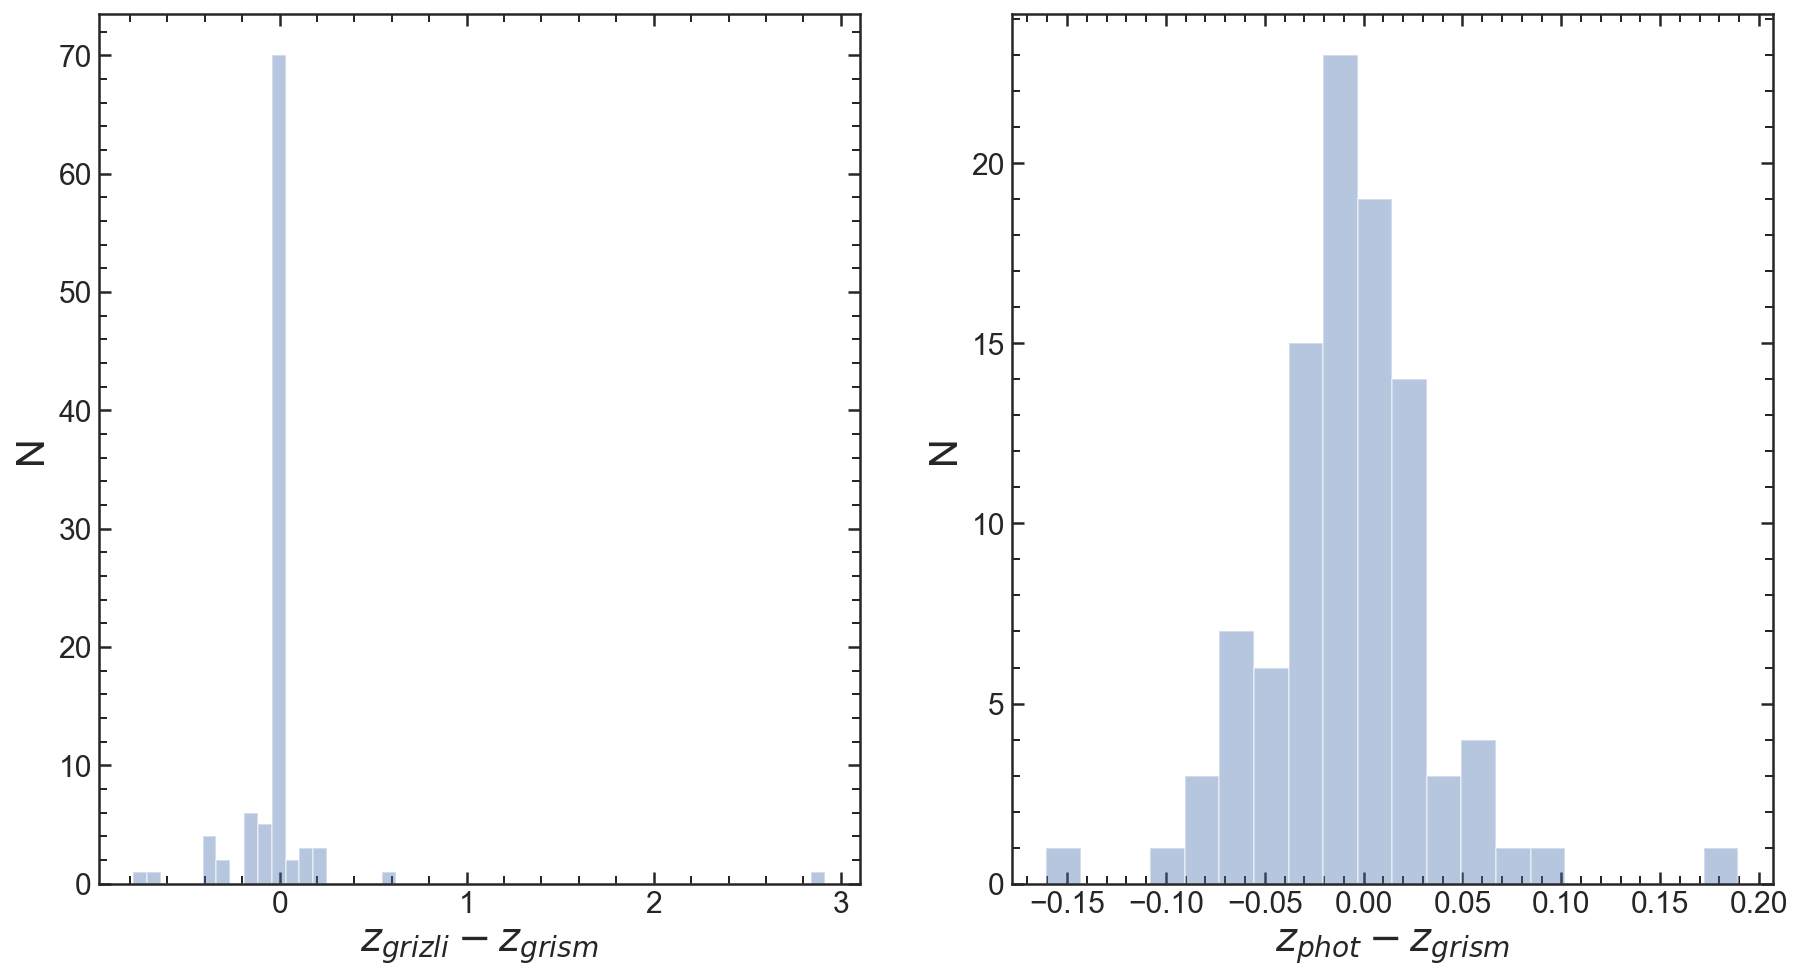

In [185]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize = [15,8])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

sea.distplot(zgrizli - mdb.zgrism, kde = False, ax = ax1)
sea.distplot(zphot - mdb.zgrism, kde = False, ax = ax2)

ax1.set_xlabel('$z_{grizli} - z_{grism}$', fontsize=20)
ax2.set_xlabel('$z_{phot} - z_{grism}$', fontsize=20)

ax1.set_ylabel('N', fontsize=20)
ax2.set_ylabel('N', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

In [194]:
from statsmodels import robust

print(robust.mad(zgrizli - mdb.zgrism))
print(robust.mad(zphot - mdb.zgrism))


0.00878871748107462
0.030858049572356862


In [197]:
large=0
for i in np.abs(zgrizli - mdb.zgrism).values:
    if i > 0.2:
        large+=1
print(large)

13


Text(0,0.5,'EAZY lmass')

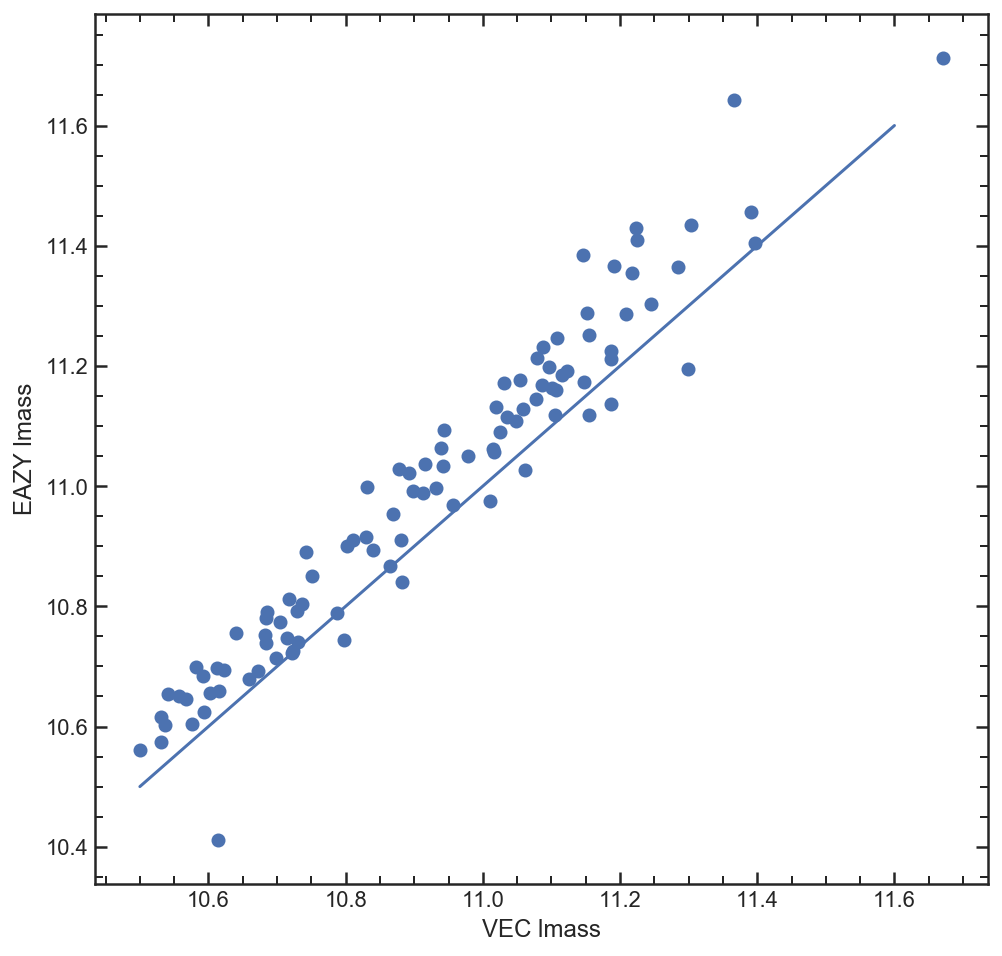

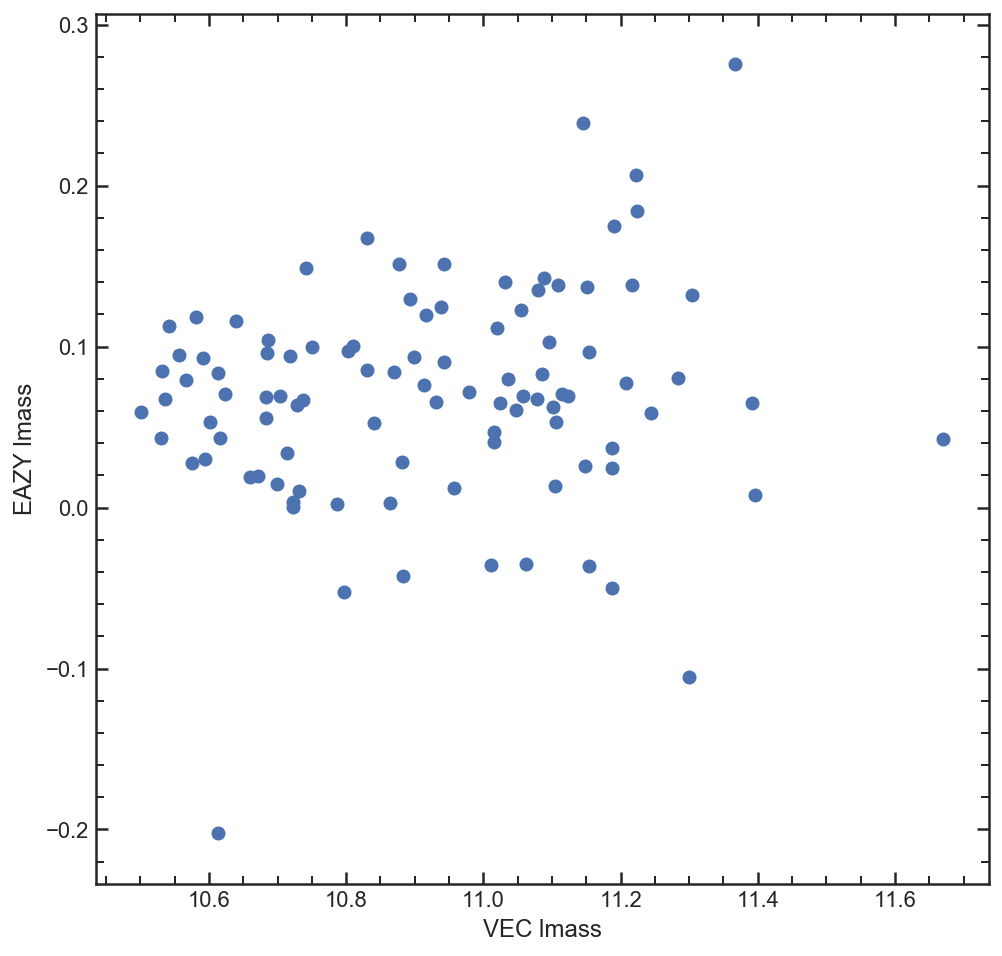

In [198]:

plt.figure(figsize=[8,8])
ax1 = plt.subplot()
ezmasses = []
for i in mdb.index:
    if mdb.field[i] == 'GSD':
        ezmass = np.log10(eazy_GSD.query('id == {}'.format(mdb.id[i])).mass.values[0])
    else:
        ezmass = np.log10(eazy_GND.query('id == {}'.format(mdb.id[i])).mass.values[0])      
    ezmasses.append(ezmass)

ezmasses = np.array(ezmasses)
    
ax1.scatter(mdb.lmass,ezmasses)

ax1.plot([10.5,11.6],[10.5,11.6])
ax1.set_xlabel('VEC lmass')
ax1.set_ylabel('EAZY lmass')


plt.figure(figsize=[8,8])
ax1 = plt.subplot()

ax1.scatter(mdb.lmass,ezmasses - mdb.lmass)
ax1.set_xlabel('VEC lmass')
ax1.set_ylabel('EAZY lmass')


In [199]:
robust.mad(ezmasses - mdb.lmass)

0.051506427149060105

In [14]:
offset = np.linspace(0.05,0.1)
chi2 = []
for i in offset:
    irange = interp1d(np.linspace(10,12), np.repeat(i, 50))
    
    chi2.append(sum(((ezmasses - mdb.lmass) - irange(mdb.lmass))**2))

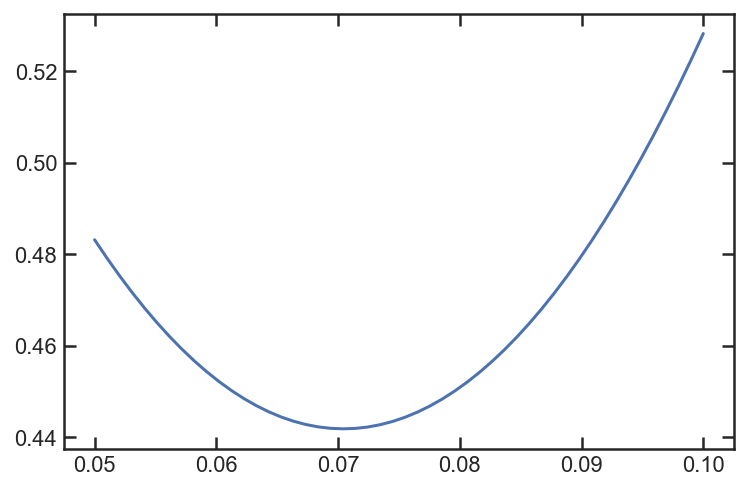

In [15]:
plt.plot(offset, chi2)

# Dust and sSFR

$\log(SFR) = \alpha \log(M/M_{9.7}) + \beta$

Redshift    | $\alpha$        | $\beta$
------------|-----------------|-----
1.3 ≤ z < 2 | 1.04 $\pm$ 0.03 | 1.01 $\pm$ 0.04
2 ≤ z < 3   | 1.16 $\pm$ 0.03 | 1.22 $\pm$ 0.03

In [218]:
def log_SFR(M, alpha, beta):
    return alpha * np.log10(M / 10**9.7) + beta

(-3, 3)

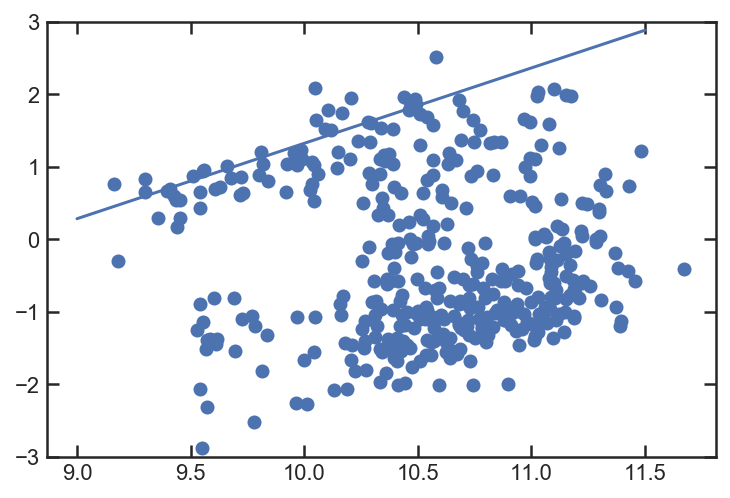

In [224]:
M = 10**np.linspace(9,11.5)

plt.scatter(alldb.lmass,np.log10(10**alldb.lmass * 10**np.array(sSFR)))
plt.plot(np.log10(M), log_SFR(M, 1.04, 1.01))

plt.ylim(-3,3)

In [151]:
sSFR = []

for idx in alldb.index: 
    try:
        with open('../data/SFH/{}_{}_1D.pkl'.format( alldb.field[idx],  alldb.id[idx]), 'rb') as sfh_file:
            SFH = pickle.load(sfh_file)

        sSFR.append(np.log10((np.trapz(SFH.SFH[:11], SFH.LBT[:11])/0.1) / 10**alldb.lmass[idx]))
    except:
        sSFR.append(-99)

In [157]:
alldb['sSFR_avg'] = sSFR

In [156]:
alldb.to_pickle('../dataframes/fitdb/allfits_1D.pkl')

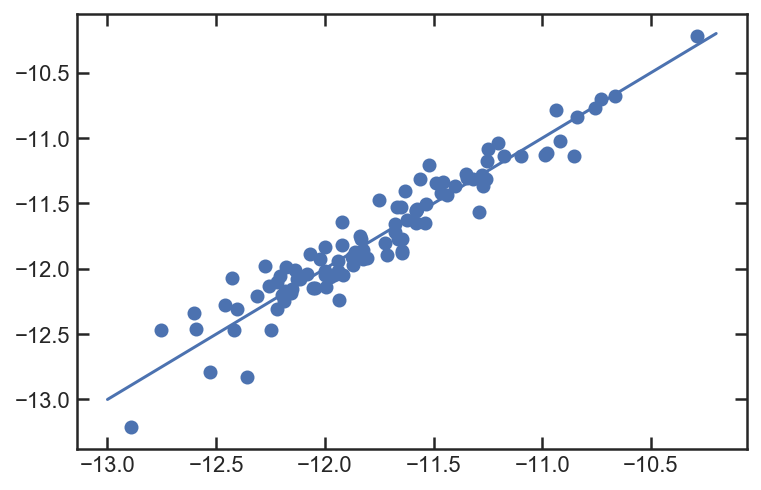

In [138]:
plt.scatter(sSFR, mdb.log_ssfr)
plt.plot([-13, -10.2],[-13, -10.2])

In [225]:
sSFR = []

for idx in mdb.index: 
    with open('../data/SFH/{}_{}_1D.pkl'.format( mdb.field[idx], mdb.id[idx]), 'rb') as sfh_file:
        SFH = pickle.load(sfh_file)

    sSFR.append(np.log10((np.trapz(SFH.SFH[:11], SFH.LBT[:11])/0.1) / 10**mdb.lmass[idx]))


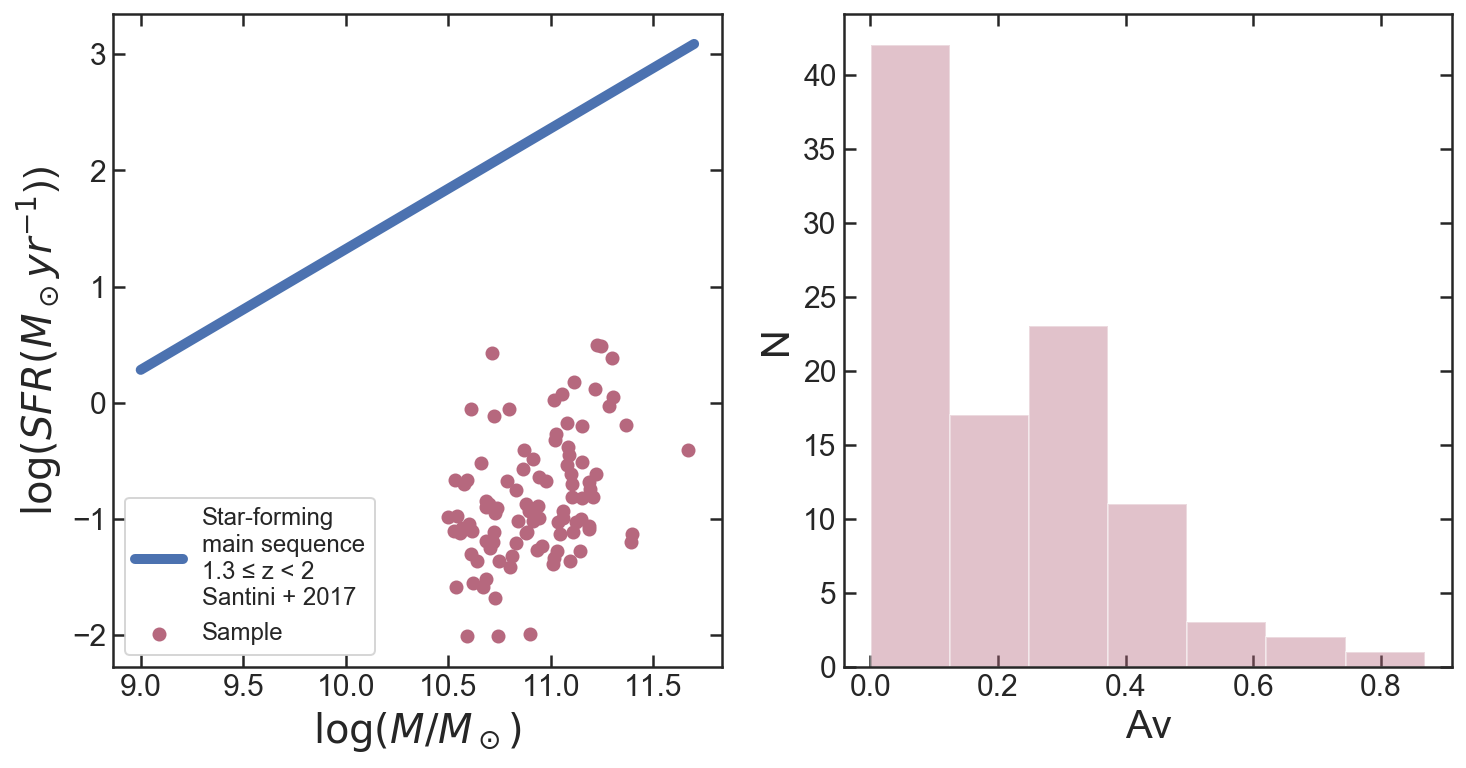

In [245]:
M = 10**np.linspace(9,11.7)

gs = gridspec.GridSpec(1,2)
plt.figure(figsize=[12,6])
ax1 = plt.subplot(gs[0])

plt.scatter(mdb.lmass,np.log10(10**mdb.lmass * 10**np.array(sSFR)), color = '#B6687E', label = 'Sample')
plt.plot(np.log10(M), log_SFR(M, 1.04, 1.01), 'b', linewidth = 5, label = 'Star-forming\nmain sequence\n1.3 ≤ z < 2\nSantini + 2017')

ax2 = plt.subplot(gs[1])
sea.distplot(mdb.Av, kde =False, color = '#B6687E')

ax1.set_ylabel('$\log(SFR (M_\odot yr^{-1}$))', fontsize=20)
ax2.set_xlabel('Av', fontsize=20)
ax1.set_xlabel('$\log(M/M_\odot)$', fontsize=20)
ax2.set_ylabel('N', fontsize=20)
ax1.legend(loc = 3, fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/sSFR_Av.png', bbox_inches = 'tight')    


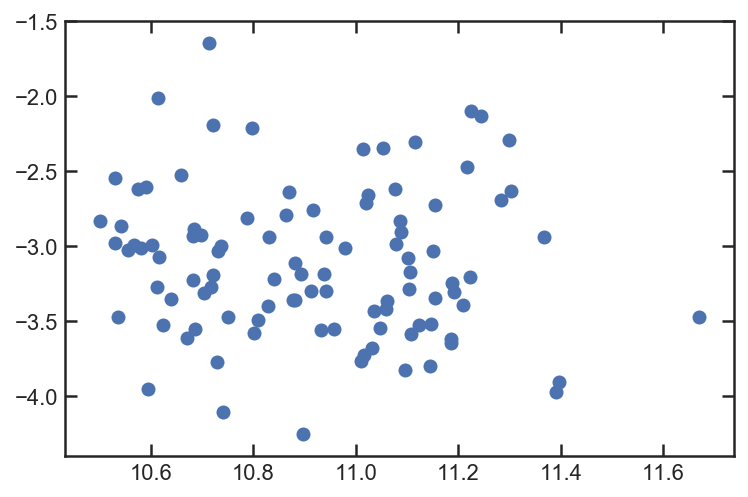

In [246]:
iSFMs = interp1d(np.log10(M),log_SFR(M, 1.04, 1.01))

plt.scatter(mdb.lmass,np.log10(10**mdb.lmass * 10**np.array(sSFR)) - iSFMs(mdb.lmass) )

In [51]:
max(sSFR)

-10.290448267914766

# emission lines

In [16]:
swave, azflux, azerror = np.load('../data/plot_points/all_stacked.npy')

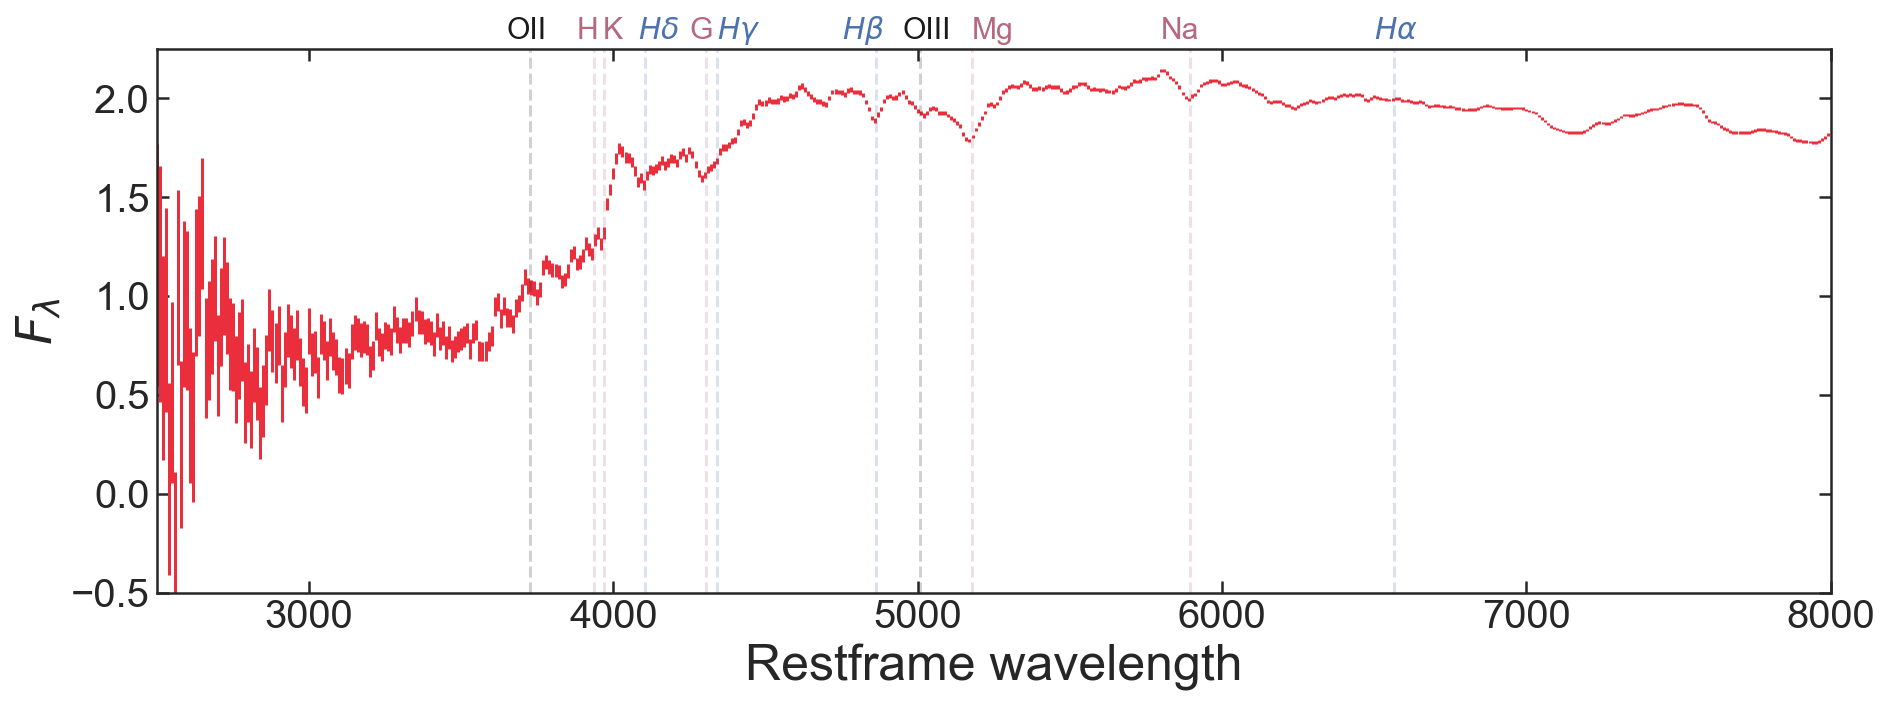

In [65]:
plt.figure(figsize=[15,5])

plt.errorbar(swave, azflux*1E3, azerror*1E3, linestyle = 'none', color='#EA2E3B',)

plt.axvline(3727 ,linestyle='--', color = 'k', alpha = 0.2)
plt.axvline(5008 ,linestyle='--', color = 'k', alpha = 0.2)

plt.axvline(3934.77 ,linestyle='--', color = '#B6687E', alpha = 0.2)
plt.axvline(3969.588 ,linestyle='--', color = '#B6687E', alpha = 0.2)
plt.axvline(4305.61 ,linestyle='--', color = '#B6687E', alpha = 0.2)
plt.axvline(5176.7,linestyle='--', color = '#B6687E', alpha = 0.2)
plt.axvline(5895.6,linestyle='--', color = '#B6687E', alpha = 0.2)

plt.axvline(4102.89 ,linestyle='--', color = 'b', alpha = 0.2)
plt.axvline(4341.68 ,linestyle='--', color = 'b', alpha = 0.2)
plt.axvline(4862.68 ,linestyle='--', color = 'b', alpha = 0.2)
plt.axvline(6564.61,linestyle='--', color = 'b', alpha = 0.2)

plt.ylabel('$F_\lambda$', fontsize=25)
plt.xlabel('Restframe wavelength', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(2500,8000)
plt.ylim(-0.5,2.25)

plt.text(3650, 2.3, 'OII', fontsize = 15, color = 'k')
plt.text(4950, 2.3, 'OIII', fontsize = 15, color = 'k')

plt.text(3880, 2.3, 'H', fontsize = 15, color = '#B6687E')
plt.text(3965, 2.3, 'K', fontsize = 15, color = '#B6687E')
plt.text(4250, 2.3, 'G', fontsize = 15, color = '#B6687E')
plt.text(5176.7, 2.3, 'Mg', fontsize = 15, color = '#B6687E')
plt.text(5800, 2.3, 'Na', fontsize = 15, color = '#B6687E')

plt.text(4080, 2.3, '$H\\delta$', fontsize = 15, color = 'b')
plt.text(4341.68, 2.3, '$H\\gamma$', fontsize = 15, color = 'b')
plt.text(4750, 2.3, '$H\\beta$', fontsize = 15, color = 'b')
plt.text(6500, 2.3, '$H\\alpha$', fontsize = 15, color = 'b')
plt.savefig('../plots/all_stack.png', bbox_inches = 'tight')

# table

In [86]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()

In [87]:
zphot = []
zphot_16 = []
zphot_84 = []

for i in mdb.index:
    gid = mdb.id[i]
    
    if mdb.field[i][1] == 'N':
        zphot.append(eazy_GND.query('id == {}'.format(gid)).z500.values[0])
        zphot_16.append(eazy_GND.query('id == {}'.format(gid)).z160.values[0])
        zphot_84.append(eazy_GND.query('id == {}'.format(gid)).z840.values[0])
        
    else:
        zphot.append(eazy_GSD.query('id == {}'.format(gid)).z500.values[0])
        zphot_16.append(eazy_GSD.query('id == {}'.format(gid)).z160.values[0])
        zphot_84.append(eazy_GSD.query('id == {}'.format(gid)).z840.values[0])
        
zphot = np.array(zphot)
zphot_16 = np.array(zphot_16)
zphot_84 = np.array(zphot_84)

In [95]:
ra = []
dec = []
massez = []
lS1 = []
dS1 = []
t_q = []
t_qerr = []

for i in mdb.index:
    if mdb.field[i] == 'GND':
        ra.append(v4N.query('id == {}'.format(mdb.id[i])).ra.values[0] )
        dec.append(v4N.query('id == {}'.format(mdb.id[i])).dec.values[0] )     
        massez.append(np.log10(eazy_GND.query('id == {}'.format(mdb.id[i])).mass.values[0]))
    if mdb.field[i] == 'GSD':
        ra.append( v4S.query('id == {}'.format(mdb.id[i])).ra.values[0] )
        dec.append( v4S.query('id == {}'.format(mdb.id[i])).dec.values[0] )  
        massez.append(np.log10(eazy_GSD.query('id == {}'.format(mdb.id[i])).mass.values[0]))

    lS1.append(np.log10(mdb.Sigma1[i]))
    dS1.append(mdb.Sigma1_nsig[i] / (mdb.Sigma1[i] * np.log(10)))
   
    t_q.append(mdb.t_50[i] - mdb.t_90[i])
    
    err = []
    for ii in range(2):
        err50 = np.abs(mdb.t_50[i] - mdb.t_50_hdr[i][ii])
        err90 = np.abs(mdb.t_90[i] - mdb.t_90_hdr[i][ii])
        
        err.append(np.sqrt(err50**2 + err90**2))
    t_qerr.append(err)

In [96]:
mdb['ra'] = ra
mdb['dec'] = dec
mdb['massez'] = massez
mdb['lS1'] = lS1
mdb['dS1'] = dS1
mdb['zphot'] = zphot
mdb['zphot_16'] = zphot_16
mdb['zphot_84'] = zphot_84
mdb['t_q'] = t_q
mdb['t_qerr'] = t_qerr
# mdb['sSFR_m'] = sSFR
# ra dec zphot, zgrism, mass ez, mass r1/2, SFR, Av, z50, Sigma1, t_Q

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [97]:
for idx in mdb.sort_values('zgrism').index:
    print('%s-%d & %f & %f & $%1.2f_{%1.2f}^{%1.2f}$ & %1.1f & $%1.2f_{%1.2f}^{%1.2f}$ \\\\' % (
    mdb.field[idx], mdb.id[idx], mdb.ra[idx], mdb.dec[idx], mdb.zphot[idx], mdb.zphot[idx]- mdb.zphot_16[idx], mdb.zphot_84[idx]- mdb.zphot[idx],
        mdb.massez[idx], mdb.Re[idx], mdb.Re_sig[idx], mdb.Re_nsig[idx]))

GND-29879 & 189.254227 & 62.291579 & $0.69_{0.01}^{0.01}$ & 10.9 & $1.12_{0.01}^{0.13}$ \\
GND-21683 & 189.318225 & 62.253421 & $0.66_{0.01}^{0.01}$ & 11.2 & $6.73_{0.03}^{0.44}$ \\
GSD-41147 & 53.081634 & -27.717718 & $0.70_{0.01}^{0.01}$ & 10.8 & $1.46_{0.01}^{0.09}$ \\
GSD-47140 & 53.131853 & -27.687304 & $0.73_{0.01}^{0.01}$ & 10.8 & $2.91_{0.04}^{0.22}$ \\
GSD-46001 & 53.120312 & -27.691486 & $0.72_{0.01}^{0.01}$ & 11.2 & $3.00_{0.02}^{0.19}$ \\
GND-27006 & 189.263714 & 62.275807 & $0.71_{0.02}^{0.02}$ & 10.8 & $1.11_{0.01}^{0.11}$ \\
GND-22358 & 189.081040 & 62.251545 & $0.82_{0.02}^{0.02}$ & 10.7 & $1.66_{0.02}^{0.12}$ \\
GND-36838 & 189.251622 & 62.344526 & $0.80_{0.02}^{0.01}$ & 10.8 & $1.46_{0.03}^{0.12}$ \\
GND-37186 & 189.243199 & 62.349892 & $0.80_{0.01}^{0.02}$ & 11.0 & $1.68_{0.03}^{0.15}$ \\
GND-13774 & 189.179829 & 62.211733 & $0.83_{0.01}^{0.01}$ & 11.1 & $1.78_{0.01}^{0.14}$ \\
GND-32108 & 189.277164 & 62.305097 & $0.82_{0.01}^{0.01}$ & 10.7 & $1.77_{0.03}^{0.15}$ \\

In [100]:
for idx in mdb.sort_values('zgrism').index:
    print('%s-%d & $%1.3f_{%1.3f}^{%1.3f}$ & $%1.2f\
_{%1.2f}^{%1.2f}$ & $%1.1f_{%1.1f}^{%1.1f}$ & $%1.2f_{%1.2f}^{%1.2f}$ & $%1.2f_{%1.2f}^{%1.2f}$ \
& $%1.1f_{%1.1f}^{%1.1f}$ & $%1.1f_{%1.1f}^{%1.1f}$ \\\\' % (
    mdb.field[idx], mdb.id[idx],mdb.zgrism[idx], 
    mdb.zgrism[idx]-mdb.zgrism_hdr[idx][0],mdb.zgrism_hdr[idx][1]-mdb.zgrism[idx], mdb.lmass[idx], 
    mdb.lmass[idx] - mdb.lmass_hdr[idx][0],mdb.lmass_hdr[idx][1]-mdb.lmass[idx],
    mdb.sSFR_avg[idx],np.abs(mdb.log_ssfr_hdr[idx][1]-mdb.sSFR_avg[idx]), 
    np.abs(mdb.sSFR_avg[idx]-mdb.log_ssfr_hdr[idx][0]), mdb.Av[idx], 
    mdb.Av_hdr[idx][0],mdb.Av_hdr[idx][1], mdb.lS1[idx], mdb.dS1[idx], mdb.dS1[idx], mdb.t_q[idx], mdb.t_qerr[idx][0], mdb.t_qerr[idx][1], mdb.z_50[idx], 
    mdb.z_50[idx]-mdb.z_50_hdr[idx][0],mdb.z_50_hdr[idx][1]-mdb.z_50[idx],))

GND-29879 & $0.711_{0.002}^{0.001}$ & $10.80_{0.03}^{0.04}$ & $-12.2_{0.5}^{0.4}$ & $0.22_{0.14}^{0.30}$ & $9.99_{0.05}^{0.05}$ & $1.3_{0.8}^{0.4}$ & $1.6_{0.2}^{0.2}$ \\
GND-21683 & $0.715_{0.004}^{0.004}$ & $11.30_{0.03}^{0.03}$ & $-10.9_{0.1}^{0.2}$ & $0.38_{0.31}^{0.45}$ & $10.21_{0.03}^{0.03}$ & $1.8_{0.7}^{0.4}$ & $2.5_{0.4}^{0.2}$ \\
GSD-41147 & $0.730_{0.002}^{0.002}$ & $10.74_{0.02}^{0.02}$ & $-11.6_{0.0}^{0.4}$ & $0.20_{0.15}^{0.24}$ & $9.96_{0.02}^{0.02}$ & $2.5_{0.5}^{0.3}$ & $2.1_{0.3}^{0.2}$ \\
GSD-47140 & $0.731_{0.002}^{0.002}$ & $10.70_{0.02}^{0.03}$ & $-12.0_{0.1}^{0.2}$ & $0.00_{0.00}^{0.02}$ & $9.71_{0.04}^{0.04}$ & $1.9_{1.1}^{0.4}$ & $2.8_{0.8}^{0.2}$ \\
GSD-46001 & $0.732_{0.001}^{0.001}$ & $11.10_{0.02}^{0.03}$ & $-11.7_{0.0}^{0.5}$ & $0.43_{0.35}^{0.47}$ & $10.05_{0.03}^{0.03}$ & $1.8_{0.8}^{0.3}$ & $1.9_{0.4}^{0.1}$ \\
GND-27006 & $0.743_{0.001}^{0.001}$ & $10.88_{0.02}^{0.04}$ & $-12.0_{0.2}^{0.6}$ & $0.26_{0.20}^{0.34}$ & $10.13_{0.04}^{0.04}$ & $2.3_{1.0}^{

In [103]:
Smdb = mdb.sort_values('zgrism')

str_id = []
for i in Smdb.index:
    str_id.append('{}-{}'.format(Smdb.field[i], Smdb.id[i]))
    
phot_df = pd.DataFrame({'ID':str_id,'ra':Smdb.ra,'dec':Smdb.dec,'zphot':Smdb.zphot,
                        'zphot_-':Smdb.zphot- Smdb.zphot_16,'zphot_+':Smdb.zphot_84- Smdb.zphot,
                        'EAZY_lmass':Smdb.massez,'Reff':Smdb.Re,'Reff_sig':Smdb.Re_nsig})

phot_df = phot_df[['ID','ra','dec','zphot','zphot_-','zphot_+','EAZY_lmass','Reff','Reff_sig']]

phot_df.to_csv('../../Vince-ec.github.io/appendix/TBL1.txt', sep = ' ', index=False)

In [104]:
Smdb = mdb.sort_values('zgrism')

str_id = []
zg_hdr_l = []
zg_hdr_h = []
lm_hdr_l = []
lm_hdr_h = []
ss_hdr_l = []
ss_hdr_h = []
av_hdr_l = []
av_hdr_h = []
z5_hdr_l = []
z5_hdr_h = []
tq_hdr_l = []
tq_hdr_h = []
for i in Smdb.index:
    str_id.append('{}-{}'.format(Smdb.field[i], Smdb.id[i]))
    zg_hdr_l.append(mdb.zgrism[i] - mdb.zgrism_hdr[i][0])
    zg_hdr_h.append(mdb.zgrism_hdr[i][1] - mdb.zgrism[i])
    lm_hdr_l.append(mdb.lmass[i] - mdb.lmass_hdr[i][0])
    lm_hdr_h.append(mdb.lmass_hdr[i][1] - mdb.lmass[i])
    ss_hdr_h.append(1*(np.abs(mdb.sSFR_avg[i]-mdb.log_ssfr_hdr[i][0])))
    ss_hdr_l.append(1*(np.abs(mdb.sSFR_avg[i]-mdb.log_ssfr_hdr[i][1])))
    av_hdr_l.append(mdb.Av[i] - mdb.Av_hdr[i][0])
    av_hdr_h.append(mdb.Av_hdr[i][1] - mdb.Av[i])
    z5_hdr_l.append(mdb.z_50[i] - mdb.z_50_hdr[i][0])
    z5_hdr_h.append(mdb.z_50_hdr[i][1] - mdb.z_50[i])
    tq_hdr_l.append(mdb.t_qerr[i][0])
    tq_hdr_h.append(mdb.t_qerr[i][1]) 
    
spec_df = pd.DataFrame({'ID':str_id,'zgrism': Smdb.zgrism,'zgrism_hdr_-': zg_hdr_l,'zgrism_hdr_+':zg_hdr_h,
                        'lmass':Smdb.lmass,'lmass_hdr_-':lm_hdr_l,'lmass_hdr_+':lm_hdr_h,'sSFR':Smdb.sSFR_avg,
                        'sSFR_hdr_-':ss_hdr_l,'sSFR_hdr_+':ss_hdr_h,'Av':Smdb.Av,'AV_hdr_-':av_hdr_l,
                        'Av_hdr_+':av_hdr_h,'lSigma1':Smdb.lS1, 'lSigma1_sig':Smdb.dS1,'tq':Smdb.t_q, 
                        'tq_hdr_-':tq_hdr_l,'tq_hdr_+':tq_hdr_h,'z50':Smdb.z_50,'z50_hdr_-':z5_hdr_l,'z50_hdr_+' : z5_hdr_h})

spec_df = spec_df[['ID','zgrism','zgrism_hdr_-','zgrism_hdr_+','lmass','lmass_hdr_-','lmass_hdr_+','sSFR','sSFR_hdr_-',
                   'sSFR_hdr_+','Av','AV_hdr_-','Av_hdr_+','lSigma1', 'lSigma1_sig','tq','tq_hdr_-',
                   'tq_hdr_+','z50','z50_hdr_-','z50_hdr_+']]

spec_df.to_csv('../../Vince-ec.github.io/appendix/TBL2.txt', sep = ' ', index=False)

In [217]:
mdb[['field','id', 'ra', 'dec', 'zphot','zphot_16','zphot_84','zgrism', 'zgrism_hdr', 'massez', 'lmass', 'lmass_hdr',
 'Re','Re_sig','sSFR_avg','log_ssfr_hdr','Av', 'Av_hdr','lS1', 'dS1','t_q', 't_qerr']].to_csv('../../Vince-ec.github.io/appendix/VEC_TBL.txt', sep=' ', index=False)

In [ ]:
'id', 'ra', 'dec', 'zphot', 'zgrism', 'massez', 'lmass', 'Re', 'sSFR_m', 'Av','lS1','t_q'

In [12]:
mdb['l_Sigma1'] = np.log10(mdb.Sigma1.values) 
mdb['c_z_50'] = cosmo.lookback_time(mdb.z_50.values).value

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
mdb.lmass[[2,14]]

2     11.114971
14    10.913285
Name: lmass, dtype: float64

In [45]:
its = 1000

M_corr = []
for xx in range(its):
    IDX = np.random.choice(mdb.index, len(mdb))
    spr = stats.spearmanr(mdb.lmass[IDX], mdb.z_50[IDX])
    M_corr.append(spr.correlation)
    
S_corr = []
for xx in range(its):
    IDX = np.random.choice(mdb.index, len(mdb))
    spr = stats.spearmanr(mdb.Sigma1[IDX], mdb.z_50[IDX])
    S_corr.append(spr.correlation)

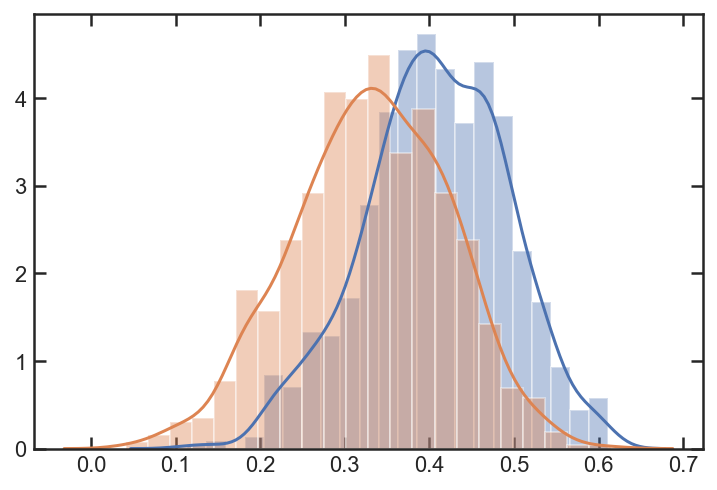

In [46]:
sea.distplot(M_corr)
sea.distplot(S_corr)

SpearmanrResult(correlation=0.08607671398369073, pvalue=0.5831216958332566)


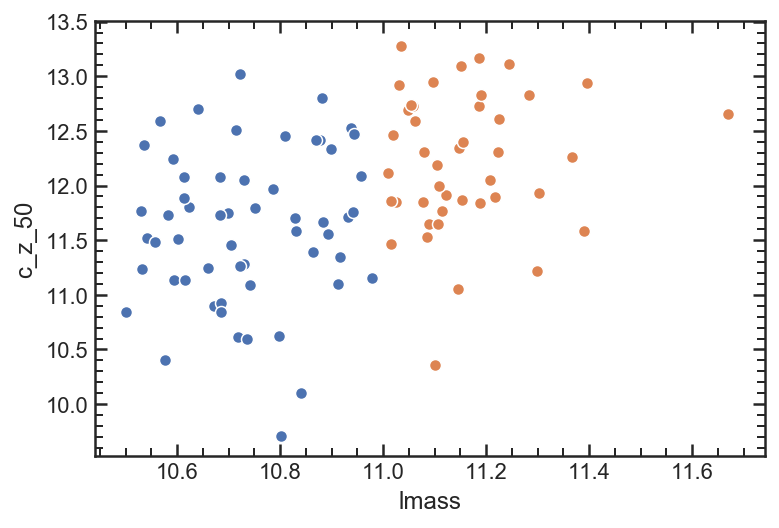

In [18]:
print(stats.spearmanr(mdb.query('lmass > 11').lmass, mdb.query('lmass > 11').c_z_50))

sea.scatterplot(mdb.lmass, mdb.c_z_50, )
sea.scatterplot(mdb.query('lmass > 11').lmass, mdb.query('lmass > 11').c_z_50, )


In [7]:
stats.spearmanr(mdb.query('lmass > 10.9').lmass, mdb.query('lmass > 10.9').z_50)

SpearmanrResult(correlation=0.23864253393665158, pvalue=0.09170694190023858)

In [14]:
stats.spearmanr(mdb.query('l_Sigma1 > 10.25').Sigma1, mdb.query('Sigma1 > 10**10.25').c_z_50)

SpearmanrResult(correlation=0.33571428571428563, pvalue=0.22121153763932594)

# sSFR selection

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('log_ssfr < -11 and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb2 = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


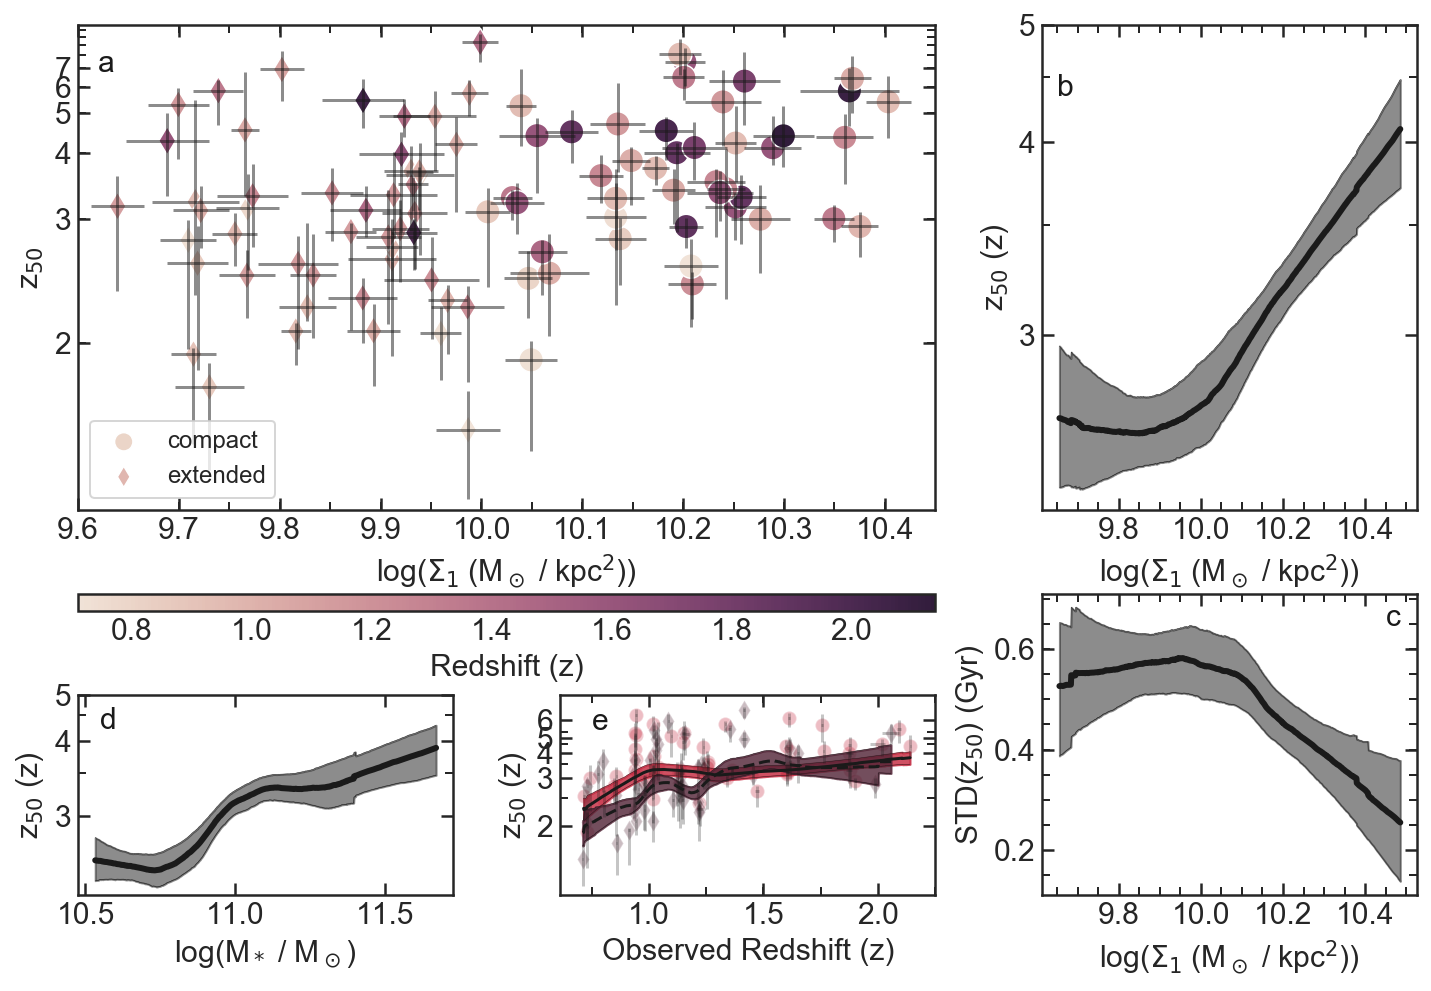

In [15]:
from matplotlib.patches import FancyBboxPatch
from matplotlib import cm
from matplotlib import colors
gs = gridspec.GridSpec(7,6,hspace=1.6,wspace=0.8, height_ratios=[1,1,1,1,.3,1,1])
cmap = sea.cubehelix_palette(light=0.9, as_cmap=True, start = 0.1)

plt.figure(figsize=[12,8])

ax1 = plt.subplot(gs[0:4,0:4])

sea.scatterplot(np.log10(mdb2.query('Sigma1 > 10**10').Sigma1), 
                cosmo.lookback_time(mdb2.query('Sigma1 > 10**10').z_50), legend=False, ax=ax1,
            alpha=1, s=150, hue = mdb2.query('Sigma1 > 10**10').zgrism, palette = cmap,
                hue_norm = (min(mdb2.zgrism),max(mdb2.zgrism)), label = 'compact')

sea.scatterplot(np.log10(mdb2.query('Sigma1 < 10**10').Sigma1), 
                cosmo.lookback_time(mdb2.query('Sigma1 < 10**10').z_50), legend=False, marker='d', ax=ax1,
            alpha=1, s=100, hue = mdb2.query('Sigma1 < 10**10').zgrism, palette = cmap,
                hue_norm = (min(mdb2.zgrism),max(mdb2.zgrism)), label = 'extended')

idx = 0
for i in mdb2.index:
    z50lerr = (cosmo.lookback_time(mdb2.z_50[i]) - cosmo.lookback_time(mdb2.z_50_hdr[i][0])).value
    z50herr = (cosmo.lookback_time(mdb2.z_50_hdr[i][1]) - cosmo.lookback_time(mdb2.z_50[i])).value

    plt.errorbar(np.log10(mdb2.Sigma1[i]), cosmo.lookback_time(mdb2.z_50[i]).value, 
                 xerr = mdb2.Sigma1_sig[i] / (mdb2.Sigma1[i] * np.log(10)), yerr = np.abs([[z50lerr], [z50herr]]), 
                 linestyle = 'none', alpha= 0.5, color = 'k')

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7]).value)
ax1.set_yticklabels([2,3,4,5,6,7])
ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,8,9,10,11]).value, minor=True)
ax1.set_ylim(cosmo.lookback_time(1.3).value,cosmo.lookback_time(12).value)
ax1.set_xticks(np.arange(10.4,9.7,-0.05), minor=True)
plt.xlim(9.6, 10.45)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=15)
plt.ylabel('z$_{50}$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12, loc = 3, markerscale = 0.75)

############ B
ax2 = plt.subplot(gs[0:4,4:])
Sx_range, Sm, Sl, Sh = np.load('../data/plot_points/Sig1_lowess_ssfr.npy')

plt.plot(Sx_range[20:], Sm[20:], 'k', linewidth = 3)
plt.plot(Sx_range[20:], Sh[20:], 'k', linewidth = 0.2)
plt.plot(Sx_range[20:], Sl[20:], 'k', linewidth = 0.2)
plt.fill_between(Sx_range[20:], Sl[20:], Sh[20:], alpha = 0.5, color = 'k')

plt.ylabel('z$_{50}$ (z)', fontsize=15)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=15)
ax2.minorticks_on()
ax2.set_yticks(cosmo.lookback_time([3,4,5]).value)
ax2.set_yticklabels([3,4,5])
ax2.set_yticks(cosmo.lookback_time([3.5,4.5]).value, minor=True)
ax2.set_xticks([9.8,10,10.2,10.4])
plt.tick_params(axis='both', which='major', labelsize=15)

############ C

ax5 = plt.subplot(gs[4:,4:])

Sx_range, Sdm, Sdl, Sdh = np.load('../data/plot_points/Sig1_sd_lowess_ssfr.npy')

plt.plot(Sx_range[20:], Sdm[20:], 'k', linewidth = 3)
plt.plot(Sx_range[20:], Sdh[20:], 'k', linewidth = 0.2)
plt.plot(Sx_range[20:], Sdl[20:], 'k', linewidth = 0.2)
plt.fill_between(Sx_range[20:], Sdl[20:], Sdh[20:], alpha = 0.5, color = 'k')

plt.ylabel('STD(z$_{50}$) (Gyr)', fontsize=15)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
ax5.minorticks_on()
ax5.set_xticks([9.8,10,10.2,10.4])

############ D

ax3 = plt.subplot(gs[5:,2:4])
Cmdb = mdb2.query('Sigma1 > {0}'.format(10**10))
Emdb = mdb2.query('Sigma1 < {0}'.format(10**10))
sea.scatterplot(Cmdb.zgrism, cosmo.lookback_time(Cmdb.z_50),
            color = '#C4253C',ax = ax3, alpha=0.3, s=50)
sea.scatterplot(Emdb.zgrism, cosmo.lookback_time(Emdb.z_50),
            color = '#502234',ax = ax3, alpha=0.3, s=50, marker = 'd')

Cx_range, Cm, Cl, Ch = np.load('../data/plot_points/compact_lowess_ssfr.npy')
Ex_range, Em, El, Eh = np.load('../data/plot_points/extend_lowess_ssfr.npy')

plt.plot(Cx_range, Cm, 'k')
plt.plot(Cx_range, Ch, 'k', linewidth = 0.2)
plt.plot(Cx_range, Cl, 'k', linewidth = 0.2)
plt.fill_between(Cx_range, Cl, Ch, alpha = 0.8, color = '#C4253C')

plt.plot(Ex_range, Em, 'k--')
plt.plot(Ex_range, Eh, 'k', linewidth = 0.2)
plt.plot(Ex_range, El, 'k', linewidth = 0.2)
plt.fill_between(Ex_range, El, Eh, alpha = 0.8, color = '#502234')


idx = 0
for i in mdb2.index:
    z50lerr = (cosmo.lookback_time(mdb2.z_50[i]) - cosmo.lookback_time(mdb2.z_50_hdr[i][0])).value
    z50herr = (cosmo.lookback_time(mdb2.z_50_hdr[i][1]) - cosmo.lookback_time(mdb2.z_50[i])).value

    zlerr = (mdb2.zgrism[i] - mdb2.zgrism_hdr[i][0])
    zherr = (mdb2.zgrism_hdr[i][1] - mdb2.zgrism[i])
    
    plt.errorbar(mdb2.zgrism[i], cosmo.lookback_time(mdb2.z_50[i]).value, 
                 xerr = np.abs([[zlerr], [zherr]]), yerr = np.abs([[z50lerr], [z50herr]]), 
                 linestyle = 'none', alpha= 0.25, color = 'k')

ax3.set_xlabel('Observed Redshift (z)', fontsize=15)
ax3.set_ylabel('z$_{50}$ (z)', fontsize=15)

ax3.set_yticks(cosmo.lookback_time([2,3,4,5,7]).value)
ax3.set_yticklabels([2,3,4,5,6,7,9])
ax3.set_xticks([0.75, 1.25, 1.5,1.75, 2.25], minor = True)
# ax3.set_xlim(0.65,2.6)
ax3.set_yticks(cosmo.lookback_time([2.5,3.5,4.5,5.5]).value, minor=True)
plt.tick_params(axis='both', which='major', labelsize=15)

############ E
ax4 = plt.subplot(gs[5:,:2])
Mx_range, Mdm, Mdl, Mdh = np.load('../data/plot_points/mass_lowess_ssfr.npy')

plt.plot(Mx_range[27:], Mdm[27:], 'k', linewidth = 3)
plt.plot(Mx_range[27:], Mdh[27:], 'k', linewidth = 0.2)
plt.plot(Mx_range[27:], Mdl[27:], 'k', linewidth = 0.2)
plt.fill_between(Mx_range[27:], Mdl[27:], Mdh[27:], alpha = 0.5, color = 'k')

plt.ylabel('z$_{50}$ (z)', fontsize=15)
plt.xlabel('log(M$_*$ / M$_\odot$)', fontsize=15)
ax4.set_yticks(cosmo.lookback_time([3,4,5]).value)
ax4.set_yticklabels([3,4,5])
ax4.set_yticks(cosmo.lookback_time([3.5,4.5]).value, minor=True)
plt.tick_params(axis='both', which='major', labelsize=15)

ax1.text(9.62, 13.,'a', fontsize = 15, color = 'k')
ax2.text(9.65, 12.4,'b', fontsize = 15, color = 'k')
ax5.text(10.45, 0.645,'c', fontsize = 15, color = 'k')
ax3.text(0.75, 12.8,'e', fontsize = 15, color = 'k')
ax4.text(10.55, 12.35,'d', fontsize = 15, color = 'k',)

ax6 = plt.subplot(gs[4,0:4])
norm = mpl.colors.Normalize(vmin=min(mdb2.zgrism), vmax = max(mdb2.zgrism))
mpl.colorbar.ColorbarBase(ax6, cmap = cmap, norm=norm, orientation='horizontal')
ax6.set_xlabel('Redshift (z)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# ax6.yaxis.set_label_position('')

plt.savefig('../plots/compact_sig1_ssfr.png', bbox_inches = 'tight')

# isolation of galaxies

In [84]:
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()

In [207]:
def Match_galaxy_single(gal_db, gid):
    r = (1. / 60 / 60) * 1 

    gra = gal_db.query('id == {}'.format(gid)).ra.values[0]
    gdec = gal_db.query('id == {}'.format(gid)).dec.values[0]
    gz = gal_db.query('id == {}'.format(gid)).z500.values[0]
        
    cat_ra = gal_db.query('id != {}'.format(gid)).ra.values
    cat_dec = gal_db.query('id != {}'.format(gid)).dec.values
    cat_ids = gal_db.query('id != {}'.format(gid)).id.values
    cat_z = gal_db.query('id != {}'.format(gid)).z500.values
    cat_mass = gal_db.query('id != {}'.format(gid)).mass.values
        
    cosr = np.sin(np.radians(gdec)) * np.sin(np.radians(cat_dec)) + np.cos(np.radians(gdec))\
            * np.cos(np.radians(cat_dec)) * np.cos(np.radians(gra) - np.radians(cat_ra))
    rad = np.arccos(cosr)
    rad = np.degrees(rad)

    cat_z -=gz

    rad[np.abs(cat_z) > 0.2] = 2000
    mass = cat_mass[rad == min(rad)]
    return min(rad)*60*60 , np.log10(mass)

In [208]:
Match_galaxy_single(v4S, 39170)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


(1.114165069606391, array([10.99186905]))

In [209]:
msep = []
cmass = []
for i in mdb.index:
    if mdb.field[i] == 'GND':
        res = Match_galaxy_single(v4N,mdb.id[i])
    else:
        res = Match_galaxy_single(v4S,mdb.id[i])
    msep.append(res[0])
    cmass.append(res[1])    

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


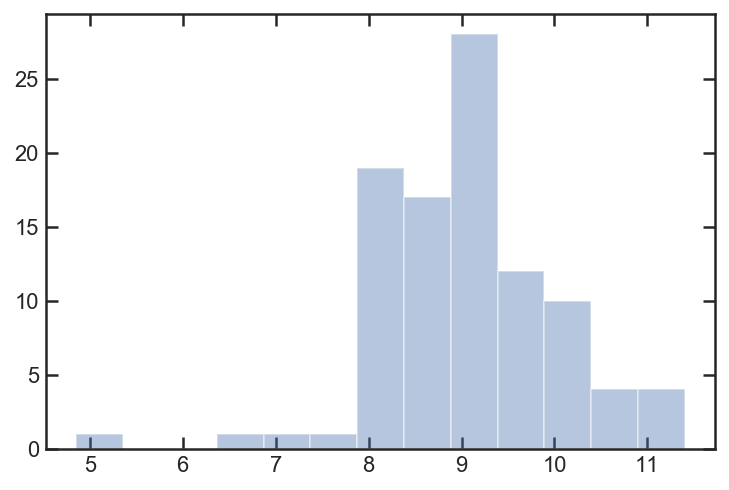

In [214]:
sea.distplot(np.array(cmass)[np.array(cmass)**2 > 0], kde = False)

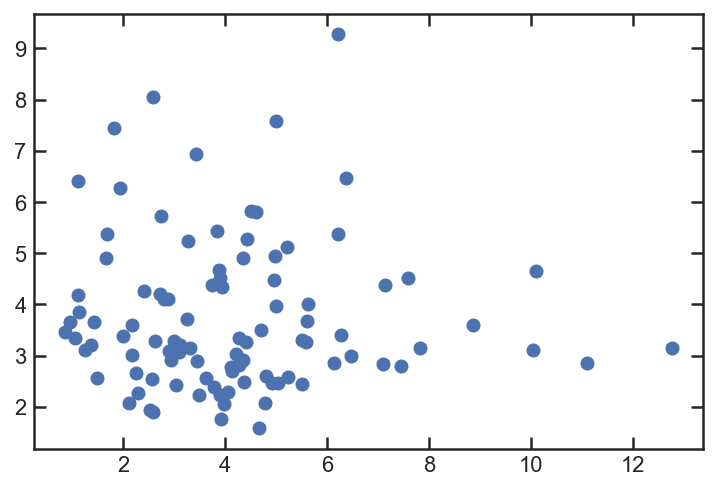

In [95]:
plt.scatter(msep, mdb.z_50)

# Merger rate

In [17]:
from spec_stats import Leave_one_out
def Sum_SFH(lbt, sfh):
    return np.sum(SFH_grid, axis=0)

def Sum_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    dt_bs = []
    w = Leave_one_out(np.array(sfh), lbt)
    wsfh = [w[U]*sfh[U] for U in range(len(sfh))]
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))            
        S= np.sum(np.array(wsfh)[IDX], axis=0)
        istack = interp1d(lbt,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)
        iT = interp1d(np.cumsum(istack[::-1]) / np.cumsum(istack[::-1])[-1], lbt - min(lbt))
        dt_bs.append(iT(0.9) - iT(0.5))
        
    sfh_bs = np.array(sfh_bs)
    dt_bs = np.array(dt_bs)
    
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    DT = np.percentile(dt_bs,50)
    DT16 = np.percentile(dt_bs,16)
    DT84 = np.percentile(dt_bs,84)
            
    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84, DT, DT16, DT84

def dt_sfh(tau,t, n = 1):
    sfh = t*np.exp(-t/tau)
    return sfh / np.trapz(sfh,t) * n

def t_star(SFH, TIME, starval):
    iT = interp1d(np.cumsum(SFH) / np.cumsum(SFH)[-1],T)
    return iT(starval)

def sfh_shift_rand(SFH, TIME):
    shift = int(np.random.choice(np.arange(0,2.5,0.1)) / 0.01)
    SFH_shift = np.append(np.zeros(shift), SFH)[:-shift]
    return SFH_shift / np.trapz(SFH_shift,TIME)

In [18]:
S1db = mdb.query('z_50 > 2.9').sort_values('Sigma1')

import pickle
from make_sfh_tool import Gen_SFH

idx = 0
LBT = np.linspace(0,14, 1000)
L=[]
S=[]
Sl=[]
Sh=[]
DT=[]
DTl=[]
DTh=[]

Sig1 = []
M = []
while idx < len(S1db.index)-14:
    SFH_grid = []
    s1_grid = []
    M_grid = []
    for i in S1db.index[idx:idx + 15]:
        try:
            lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(S1db.field[i], S1db.id[i]))
            
        except:
            try:
                with open('../data/SFH/{}_{}.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH 
                
            except:
                with open('../data/SFH/{}_{}_1D.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH                
                
        isfh = interp1d(lbt+cosmo.lookback_time(S1db.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
#         SFH_grid.append(isfh/ np.trapz(isfh, LBT))
        SFH_grid.append(isfh)
        s1_grid.append(S1db.Sigma1[i])
        M_grid.append(10**S1db.lmass[i])
    
#     L1,S1,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its=50)
    L1,S1,S16,S84,dt, dt16, dt84  = Sum_SFH_bs(LBT, SFH_grid)
    L.append(L1)
    S.append(S1)
    Sl.append(S16)
    Sh.append(S84)
    DT.append(dt)
    DTl.append(dt16)
    DTh.append(dt84)
    
    Sig1.append(np.mean(s1_grid))
    M.append(np.mean(M_grid))
    
    idx+=1

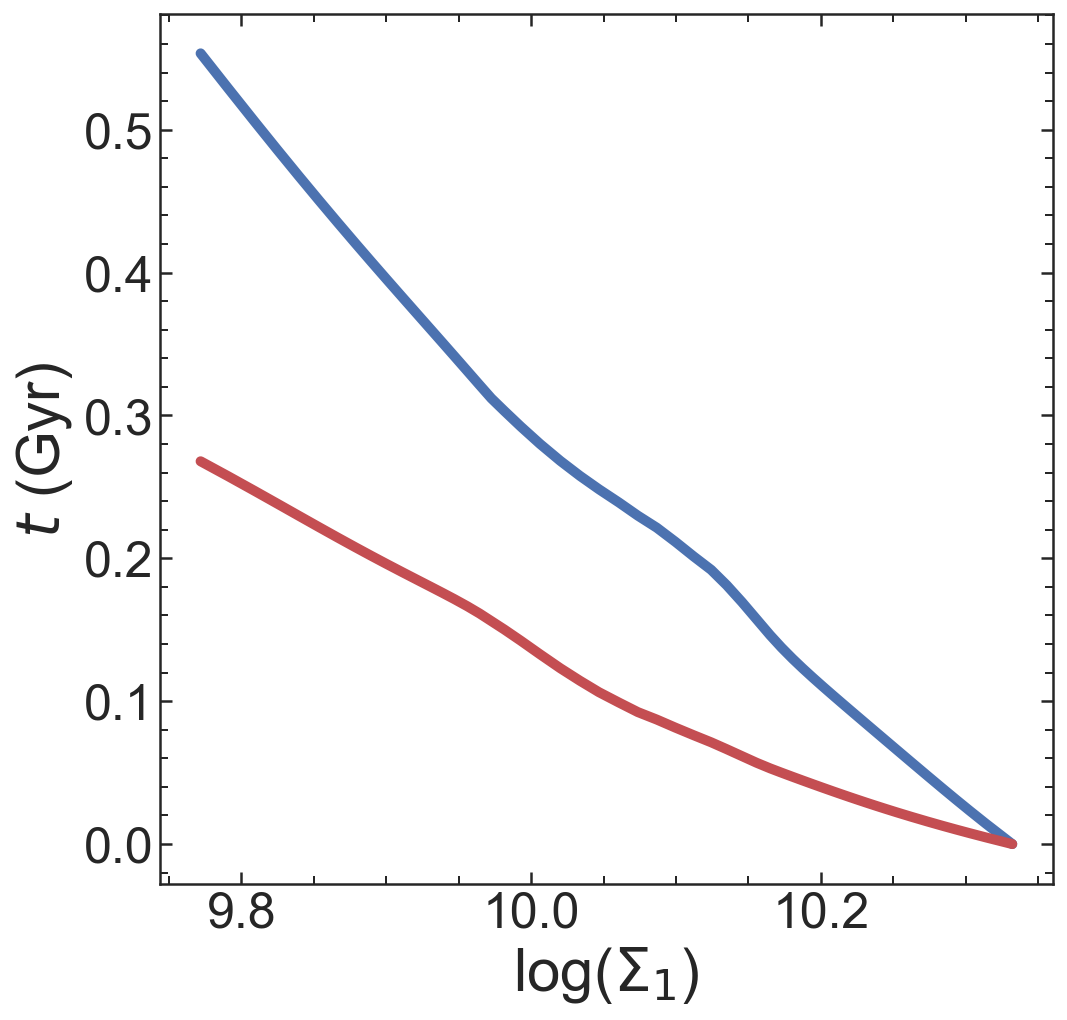

In [34]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

plt.figure(figsize=[8,8])
ax3 = plt.subplot()
dt50 = []
dtq = []


for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))
    dtq.append(iT(0.9)-iT(0.5))
    dt50.append(iT(0.5))

Q = lowess(dtq, np.log10(Sig1))
plt.plot(Q[:, 0], Q[:, 1] - Q[:,1][-1], linewidth=5, color = 'b')
 
fif = lowess(dt50,np.log10(Sig1))
plt.plot(fif[:, 0], fif[:, 1] - fif[:,1][-1], linewidth=5, color = 'r')
    
# sea.scatterplot(np.log10(Sig1), dtq)
# sea.scatterplot(np.log10(Sig1), dt50)
    
ax3.set_ylabel('$t$ (Gyr)', fontsize=30)
ax3.set_xlabel('log($\Sigma_1$)', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=25)


In [38]:
Q[:, 1] - Q[:,1][-1]

array([0.55346095, 0.52888455, 0.5056534 , 0.4861867 , 0.46763493,
       0.45074513, 0.43476465, 0.42033621, 0.40769422, 0.39552336,
       0.38280343, 0.37028763, 0.35998142, 0.35092501, 0.34154261,
       0.33116194, 0.3213509 , 0.31199158, 0.3030727 , 0.29225697,
       0.28010535, 0.26821502, 0.25772005, 0.24834541, 0.23911302,
       0.22987656, 0.22142079, 0.21150074, 0.20130648, 0.19194045,
       0.1811856 , 0.16935664, 0.15725618, 0.14626404, 0.13762082,
       0.12982079, 0.12312554, 0.1166057 , 0.11028951, 0.10424329,
       0.09863746, 0.09373986, 0.08926289, 0.08423189, 0.07865994,
       0.07263999, 0.06612284, 0.05724422, 0.04793274, 0.03899187,
       0.03117768, 0.02334384, 0.01415875, 0.        ])

In [70]:
T = np.arange(0,5.8,0.01)
gs = gridspec.GridSpec(1,2)
merges = []
d_dt = []

for xx in range(1000):
    SFH = dt_sfh(np.random.choice(np.arange(0.01,0.6,0.01)),T)
    t50 = t_star(SFH, T, 0.5)
    t90 = t_star(SFH, T, 0.9)
    dt = t90 - t50

    dt50 = 0
    dtdt = 0
    x=0


    while dt50 < 0.55:
        sfh = dt_sfh(np.random.choice(np.arange(0.01,3,0.01)) ,T,np.random.choice(np.arange(0.1,0.25,0.001)))
        SFH += sfh

        t50_2 = t_star(SFH, T, 0.5)
        t90_2 = t_star(SFH, T, 0.9)
        dt_2 = t90_2 - t50_2
        dt50 = t50_2 - t50
        dtdt = dt_2 - dt

        x+=1
    merges.append(x)
    d_dt.append(dtdt)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


7.0 11.0 17.0
1.7261142210699778 2.357769689215954 3.0543328976093345


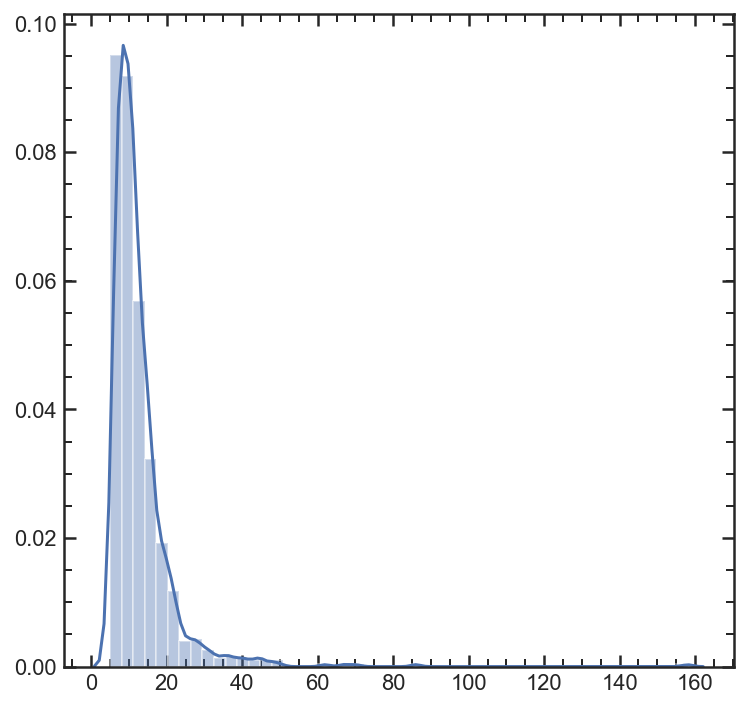

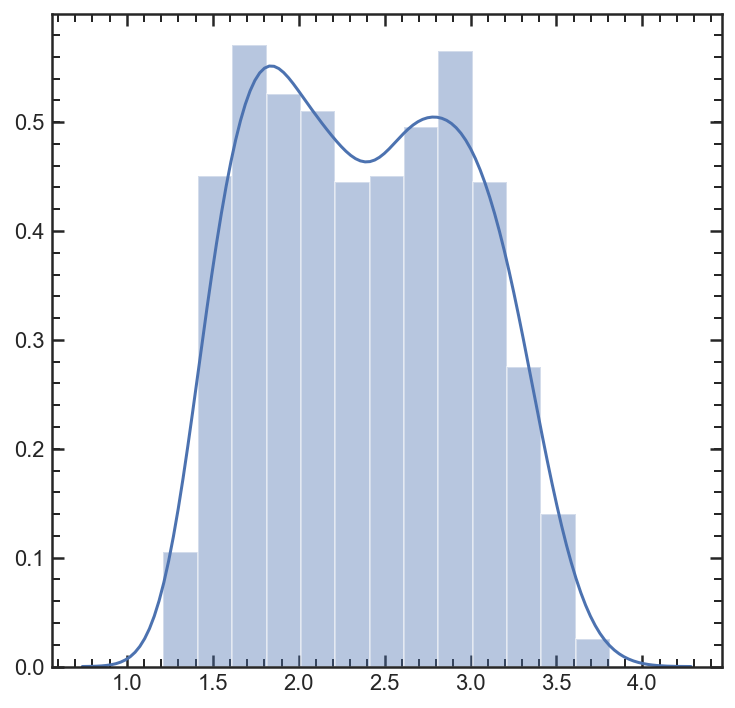

In [71]:
plt.figure(figsize=[6,6])
sea.distplot(merges)
plt.figure(figsize=[6,6])
sea.distplot(d_dt)

print(np.percentile(merges,16),np.percentile(merges,50),np.percentile(merges,84))
print(np.percentile(d_dt,16),np.percentile(d_dt,50),np.percentile(d_dt,84))

In [107]:
T = np.arange(0,5.8,0.01)

d_t50 = []
d_dt = []

for x in range(1000):
    SFH = dt_sfh(np.random.choice(np.arange(0.01,0.6,0.01)),T)
    t50 = t_star(SFH, T, 0.5)
    t90 = t_star(SFH, T, 0.9)
    dt = t90 - t50
    
    mergers = np.random.choice(np.arange(0,9).astype(int))
    
    for x in range(mergers):
        sfh = dt_sfh(np.random.choice(np.arange(0.01,3,0.01)) ,T,0.1)
        SFH += sfh

    t50_2 = t_star(SFH, T, 0.5)
    t90_2 = t_star(SFH, T, 0.9)
    dt_2 = t90_2 - t50_2

    d_t50.append(x)
    d_dt.append(dt_2 - dt)

In [ ]:
import scipy.optimize

# plt.figure(figsize = [8,8])
# sea.scatterplot(d_t50, d_dt, label = 'minor')
# sea.scatterplot(D_t50, D_dt, label = 'major')
# plt.xlabel('$\Delta t_{50}$ (Gyr)', fontsize=25)
# plt.ylabel('$\Delta t_{Q}$ (Gyr)', fontsize=25)
# plt.tick_params(axis='both', which='major', labelsize=20)
# plt.legend(loc = 2, fontsize = 20)


plt.figure(figsize=[8,8])

plt.errorbar(np.percentile(D_t50,50),np.percentile(D_dt,50),
            xerr =  [[np.percentile(D_t50,50) - np.percentile(D_t50,16)], [np.percentile(D_t50,84) - np.percentile(D_t50,50)]],
            yerr =  [[np.percentile(D_dt,50) - np.percentile(D_dt,16)], [np.percentile(D_dt,84) - np.percentile(D_dt,50)]], 
            linewidth = 5, label = 'major', barsabove = True, capsize = 10, color = 'r')

plt.errorbar(np.percentile(d_t50,50),np.percentile(d_dt,50),
            xerr =  [[np.percentile(d_t50,50) - np.percentile(d_t50,16)], [np.percentile(d_t50,84) - np.percentile(d_t50,50)]],
            yerr =  [[np.percentile(d_dt,50) - np.percentile(d_dt,16)], [np.percentile(d_dt,84) - np.percentile(d_dt,50)]], 
            linewidth = 5, label = 'minor', barsabove = True, capsize = 10, color = 'b')

plt.xlim(-0.5,0.5)
plt.ylim(-0.3,2.4)

plt.xlabel('$\Delta t_{50}$ (Gyr)', fontsize=25)
plt.ylabel('$\Delta t_{Q}$ (Gyr)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.annotate('minor\nmergers', xy=(0.1, 1.),  xycoords='data',
            xytext=(0.3, 1.5), textcoords='data',
            arrowprops=dict(facecolor='b', shrink=0.05),
            horizontalalignment='left', verticalalignment='top', fontsize = 20
            )

plt.annotate('major\nmergers', xy=(-0.025, .1),  xycoords='data',
            xytext=(-.3, .5), textcoords='data',
            arrowprops=dict(facecolor='r', shrink=0.05),
            horizontalalignment='left', verticalalignment='top', fontsize = 20
            )

# plt.savefig('../plots/mergers_aas.png', bbox_inches = 'tight')

# Mergers

In [199]:
from bokeh_scripts import img_ext
IMG = img_ext('GSD', 42221)


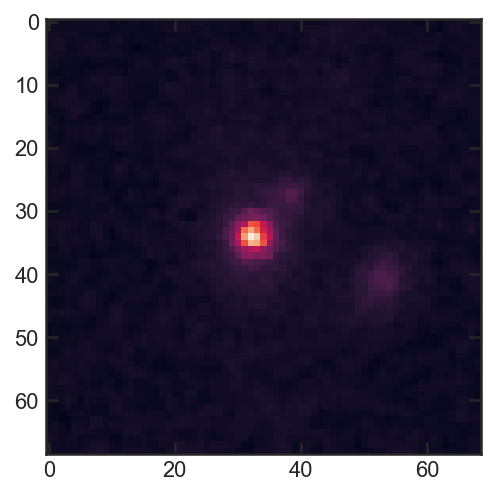

In [200]:
plt.imshow(IMG)

In [201]:
def ring_smooth(IMG,rad = 9):
    nimg = np.zeros_like(IMG)
    for i in range(len(IMG)):
        for ii in range(len(IMG[0])):
            ring = []
            for x in range(len(IMG)):
                for xx in range(len(IMG[0])):
                    x2 = x
                    x1 = i

                    y2 = xx
                    y1 = ii

                    if np.sqrt((x2 - x1)**2 +(y2 - y1)**2) <= 9:
                        ring.append(IMG[x,xx])

            nimg[i,ii] = np.median(ring)
            
    return nimg

In [202]:
NIMG = ring_smooth(IMG)

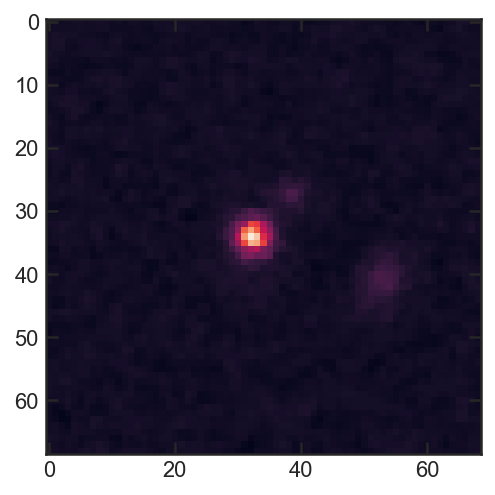

In [203]:
plt.imshow(IMG - NIMG)

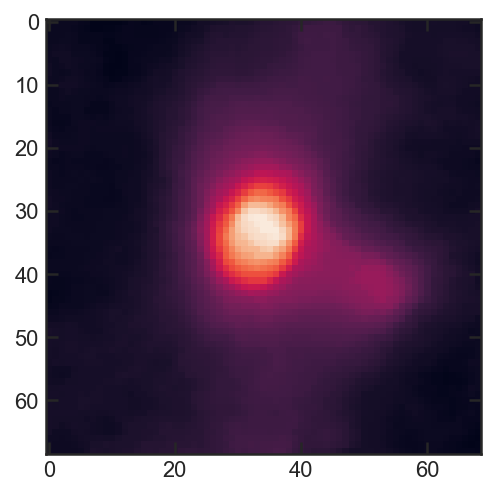

In [204]:
plt.imshow(NIMG)

In [70]:
Gs = Gen_spec(mdb.field[idx], mdb.id[idx], mdb.zgrism[idx], g102_lims=[8300, 11288], 
                 g141_lims=[11288, 16500],phot_errterm = 0.04, irac_err = 0.08,) 
Gs2 = Gen_spec_2D(mdb.field[idx], mdb.id[idx], mdb.zgrism[idx], g102_lims=[8300, 11288], 
                 g141_lims=[11288, 16500],phot_errterm = 0.04, irac_err = 0.08,) 

1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


21 ibhj23sxq_flt.fits G141
22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141
25 ib6o23ruq_flt.fits G141
26 ib6o23ryq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


21 ibhj23sxq_flt.fits G141
22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141
25 ib6o23ruq_flt.fits G141
26 ib6o23ryq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ibhj23sxq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141
25 ib6o23ruq_flt.fits G141
26 ib6o23ryq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)

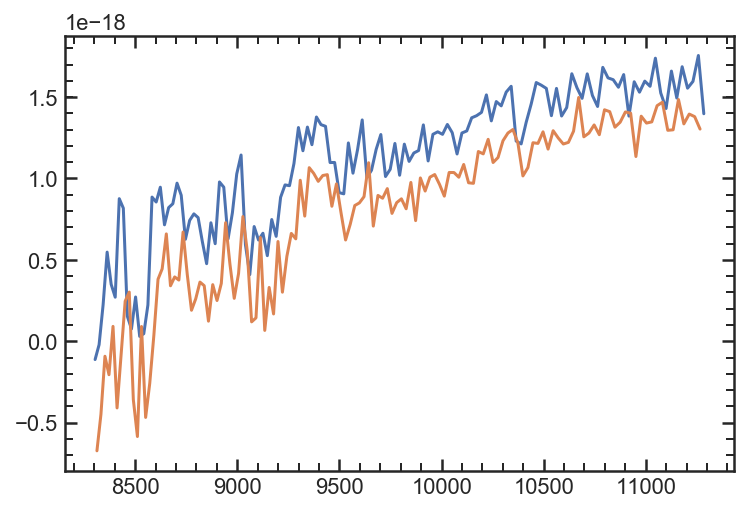

In [124]:
plt.plot(Gs.Bwv, Gs.Bfl)
# plt.plot(Gs2.Bwv, Gs2.Bfl + np.abs(min(Gs2.Bfl))*1.01)
plt.plot(Gs2.Bwv, Gs2.Bfl)


In [73]:
B_BEAM, B_TRANS = load_beams_and_trns(Gs2.mb_g102, Gs2.Bwv)

In [103]:
Xfl, Xer, Mfl = Best_fit_scale_flam(Gs2.Bwv, Gs2.Bfl, Gs2.Ber, B_BEAM, B_TRANS, wave, spec, mdb.zgrism[idx], bp1)


In [55]:
print(mdb.field[idx], mdb.id[idx])

GSD 40862


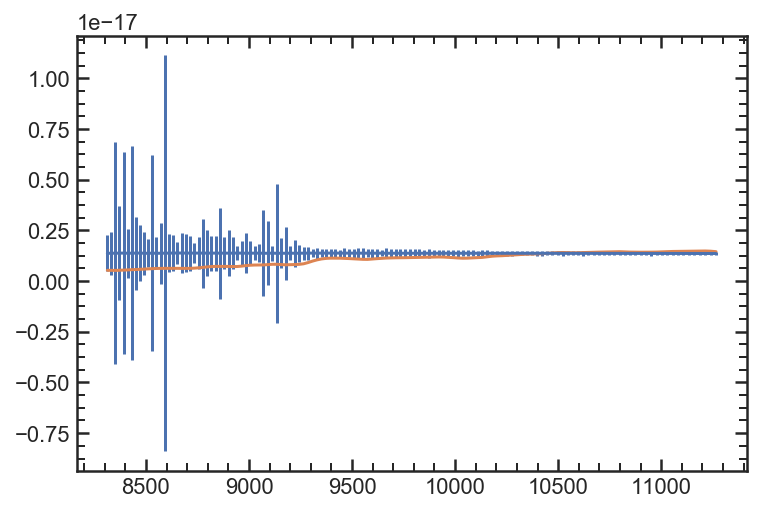

In [104]:
# plt.plot(Gs.Bwv, Gs.Bfl)
plt.errorbar(Gs2.Bwv, Xfl, Xer)
plt.plot(Gs2.Bwv, Mfl)

In [117]:
Fprime = Gs2.Bfl + 1E-16
SNR = np.abs(Gs2.Bfl/Gs2.Ber) 
theta = Gs2.Ber/Gs2.Bfl + 1E-16
Eprime = Gs2.Ber + theta

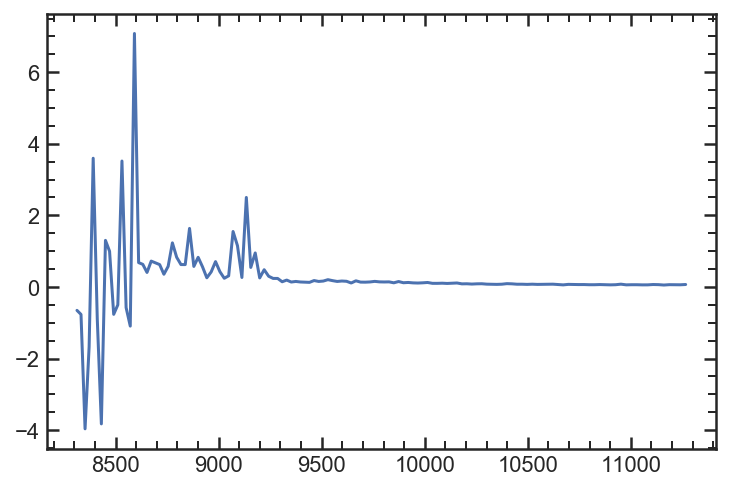

In [118]:
plt.plot(Gs2.Bwv, Eprime)

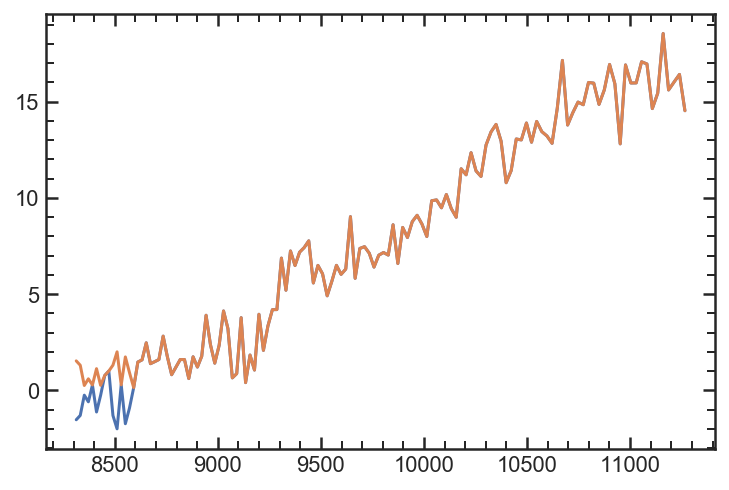

In [116]:
plt.plot(Gs2.Bwv, Gs2.Bfl/Gs2.Ber)
plt.plot(Gs2.Bwv, (Xfl/ Xer))

In [7]:
def Plot_grism_fit(MB, fit, instr, ax, color, lims):
    spec = fit['line1d'].wave, fit['line1d'].flux
    spf = fit['line1d'].wave, fit['line1d'].wave*0+1


    for i in range(MB.N):
        beam = MB.beams[i]
        b_mask = beam.fit_mask.reshape(beam.sh)

        m_i = beam.compute_model(spectrum_1d=spec, is_cgs=True, in_place=False).reshape(beam.sh)
        f_i = beam.compute_model(spectrum_1d=spf, is_cgs=True, in_place=False).reshape(beam.sh)

        grism = beam.grism.filter

        w, flm, erm = beam.beam.optimal_extract(m_i, bin=1, ivar=beam.ivar*b_mask)
        w, sens, ers = beam.beam.optimal_extract(f_i, bin=1, ivar=beam.ivar*b_mask)

        sens[~np.isfinite(sens)] = 1

        unit_corr = 1./sens

        clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1]]

        flm *= unit_corr

        ax.plot(w[clip], flm[clip], color='k', alpha=0.5, linewidth=1, zorder=2) 

    sptbl = MB.oned_spectrum(tfit = fit)

    w = sptbl[instr]['wave']
    f = sptbl[instr]['flux']
    e = sptbl[instr]['err']
    fl = sptbl[instr]['flat']
        
    clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1]]

    ax.errorbar(w[clip],f[clip]/fl[clip],e[clip]/fl[clip], color = color,
                linestyle='None', marker='o', markersize=0.25, zorder = 1, elinewidth = 1)
    
def Extract_grism_fit(MB, fit, instr, lims):
    spec = fit['line1d'].wave, fit['line1d'].flux
    spf = fit['line1d'].wave, fit['line1d'].wave*0+1
    sptbl = MB.oned_spectrum(tfit = fit)

    W = sptbl[instr]['wave']

    fgrid = np.zeros([MB.N, len(W)])
    
    for i in range(MB.N):
        beam = MB.beams[i]
        b_mask = beam.fit_mask.reshape(beam.sh)

        m_i = beam.compute_model(spectrum_1d=spec, is_cgs=True, in_place=False).reshape(beam.sh)
        f_i = beam.compute_model(spectrum_1d=spf, is_cgs=True, in_place=False).reshape(beam.sh)

        grism = beam.grism.filter

        w, flm, erm = beam.beam.optimal_extract(m_i, bin=1, ivar=beam.ivar*b_mask)
        w, sens, ers = beam.beam.optimal_extract(f_i, bin=1, ivar=beam.ivar*b_mask)

        sens[~np.isfinite(sens)] = 1

        unit_corr = 1./sens

        clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1]]

        flm *= unit_corr
        
        FLUX = interp1d(w,flm, bounds_error=False, fill_value=0)(W)
        
        for ii in range(len(FLUX)):
            if not FLUX[ii]**2 > 0:
                FLUX[ii] = 0
        
        fgrid[i] = FLUX        
    
    w = sptbl[instr]['wave']
    f = sptbl[instr]['flux']
    e = sptbl[instr]['err']
    fl = sptbl[instr]['flat']
    m = []
    
    for ff in fgrid.T:
        m.append(np.mean(ff[ff>0]))
    clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1] and f[U]**2 > 0 and m[U] > 0]
    return w[clip], f[clip]/fl[clip], e[clip]/fl[clip], np.array(m)[clip]


In [149]:
w,f,e,m = Extract_grism_fit(Gs2.mb_g102, fit, 'G102', [8300,11500])


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)


In [155]:
S1 = Scale_model(interp1d(wave*(1+mdb.zgrism[idx]),spec)(w), np.ones_like(w), m)
S2 = Scale_model(f,e, m*S1)

(8000, 11500)

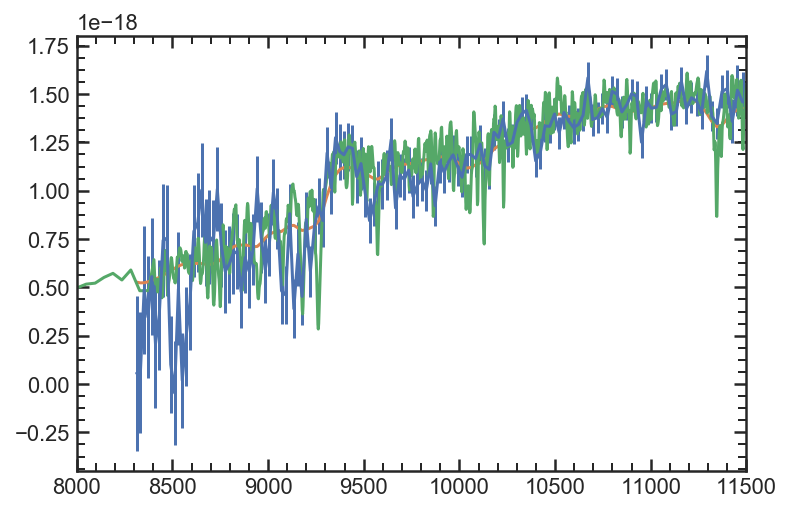

In [156]:
plt.errorbar(w,f/S2,e/S2)
plt.plot(w,m*S1)

plt.plot(wave*(1+mdb.zgrism[idx]),spec)
plt.xlim(8000,11500)

In [ ]:
# from spec_exam import Gen_spec_2D

temps = {}
# idx = mdb.query('id == 39170').index.values[0]
for idx in mdb.index:
    Gs = Gen_spec_2D(mdb.field[idx], mdb.id[idx], mdb.zgrism[idx], g102_lims=[8300, 11288], 
                     g141_lims=[11288, 16500],phot_errterm = 0.04, irac_err = 0.08,) 
    #     Flam = Posterior_spec(mdb.field[idx], mdb.id[idx])
    wave, spec = np.load('../data/allsed/phot/{}-{}_mod.npy'.format(mdb.field[idx], mdb.id[idx]))
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(mdb.field[idx], mdb.id[idx]))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(mdb.field[idx], mdb.id[idx]))
    rp1 = x[px == max(px)][0]

    #     np.save('../data/allsed/phot/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[Gs.Pwv, Gs.Pflx, Gs.Perr])

    if Gs.g102:
        np.save('../data/allsed/g102/{}-{}_O'.format(mdb.field[idx], mdb.id[idx]),[Gs.Bwv, Gs.Bfl, Gs.Ber])
    if Gs.g141:
        np.save('../data/allsed/g141/{}-{}_O'.format(mdb.field[idx], mdb.id[idx]),[Gs.Rwv, Gs.Rfl, Gs.Rer])

    # Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)   

    if Gs.g102:
        temps['fsps_model'] = SpectrumTemplate(wave=wave, flux=spec*1E18)
        fit = Gs.mb_g102.template_at_z(mdb.zgrism[idx], templates = temps, fitter='lstsq')
        w,f,e,m = Extract_grism_fit(Gs.mb_g102, fit, 'G102', [8300,11300])
        S1 = Scale_model(interp1d(wave*(1+mdb.zgrism[idx]),spec)(w), np.ones_like(w), m)
        S2 = Scale_model(f,e, m*S1)
        np.save('../data/allsed/g102/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[w,f/S2,e/S2])
        np.save('../data/allsed/g102/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[w,m*S1])

    if Gs.g141:
        temps['fsps_model'] = SpectrumTemplate(wave=wave, flux=spec*1E18)
        fit = Gs.mb_g141.template_at_z(mdb.zgrism[idx], templates = temps, fitter='lstsq')
        w,f,e,m = Extract_grism_fit(Gs.mb_g141, fit, 'G141', [11300, 16500])
        S1 = Scale_model(interp1d(wave*(1+mdb.zgrism[idx]),spec)(w), np.ones_like(w), m)
        S2 = Scale_model(f,e, m*S1)
        np.save('../data/allsed/g141/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[w,f/S2,e/S2])
        np.save('../data/allsed/g141/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[w,m*S1])
    #     np.save('../data/allsed/phot/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[Flam.wave,Flam.SPEC])

1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


21 ibhj23sxq_flt.fits G141
22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141
25 ib6o23ruq_flt.fits G141
26 ib6o23ryq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)

1 ibhj29ncq_flt.fits G141
2 ibhj29nkq_flt.fits G141
3 ibhj29nsq_flt.fits G141
4 ibhj29nzq_flt.fits G141
5 icxt32nlq_flt.fits G102
6 icxt32nmq_flt.fits G102
7 icxt32npq_flt.fits G102
8 icxt32nrq_flt.fits G102
9 icxt33roq_flt.fits G102
10 icxt33rpq_flt.fits G102
11 icxt33rsq_flt.fits G102
12 icxt33ruq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


13 icxt30s0q_flt.fits G102
14 icxt30s2q_flt.fits G102
15 icxt30s5q_flt.fits G102
16 icxt30s7q_flt.fits G102
17 icxt31r1q_flt.fits G102
18 icxt31r3q_flt.fits G102
19 icxt31r6q_flt.fits G102
20 icxt31r8q_flt.fits G102
21 icxt34ekq_flt.fits G102
22 icxt34emq_flt.fits G102
23 icxt34epq_flt.fits G102
24 icxt34erq_flt.fits G102
25 icxt35s4q_flt.fits G102
26 icxt35s6q_flt.fits G102
27 icxt35s9q_flt.fits G102
28 icxt35sbq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:842: RuntimeWarning: invalid value encountered in true_divide
  return w[clip], f[clip]/fl[clip], e[clip]/fl[clip]
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/si

1 icat19u2q_flt.fits G102
2 icat19u7q_flt.fits G102
3 icat19ueq_flt.fits G102
4 icat19ujq_flt.fits G102
5 ib3719ukq_flt.fits G141
6 ib3719uoq_flt.fits G141
7 ib3719v7q_flt.fits G141
8 ib3719vbq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:842: RuntimeWarning: invalid value encountered in true_divide
  return w[clip], f[clip]/fl[clip], e[clip]/fl[clip]
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13

1 icat03dzq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


2 icat03e4q_flt.fits G102
3 icat03ebq_flt.fits G102
4 icat03egq_flt.fits G102
5 icka01t7q_flt.fits G141
6 icka01t8q_flt.fits G141
7 icka01tgq_flt.fits G141
8 icka01tiq_flt.fits G141
9 icka02uoq_flt.fits G141
10 icka02upq_flt.fits G141
11 icka02uxq_flt.fits G141
12 icka02uzq_flt.fits G141
13 icka03d4q_flt.fits G141
14 icka03d5q_flt.fits G141
15 icka03ddq_flt.fits G141
16 icka03dfq_flt.fits G141
17 icka04pcq_flt.fits G141
18 icka04pdq_flt.fits G141
19 icka04plq_flt.fits G141
20 icka04pnq_flt.fits G141
21 icka05pjq_flt.fits G141
22 icka05pkq_flt.fits G141
23 icka05psq_flt.fits G141
24 icka05puq_flt.fits G141
25 icka06g7q_flt.fits G141
26 icka06g8q_flt.fits G141
27 icka06ggq_flt.fits G141
28 icka06giq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vi

1 icat21cfq_flt.fits G102
2 icat21coq_flt.fits G102
3 icat21dgq_flt.fits G102
4 icat21dlq_flt.fits G102
5 icxt55krq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


6 icxt55ksq_flt.fits G102
7 icxt55kvq_flt.fits G102
8 icxt55kxq_flt.fits G102
9 icxta4mdq_flt.fits G102
10 icxta4meq_flt.fits G102
11 icxta4mhq_flt.fits G102
12 icxta4mjq_flt.fits G102
13 icxt52i0q_flt.fits G102
14 icxt52i1q_flt.fits G102
15 icxt52i4q_flt.fits G102
16 icxt52i6q_flt.fits G102
17 icxt53i9q_flt.fits G102
18 icxt53iaq_flt.fits G102
19 icxt53idq_flt.fits G102
20 icxt53ifq_flt.fits G102
21 icxt51jvq_flt.fits G102
22 icxt51jwq_flt.fits G102
23 icxt51jzq_flt.fits G102
24 icxt51k1q_flt.fits G102
25 ib3721xiq_flt.fits G141
26 ib3721xmq_flt.fits G141
27 ib3721xyq_flt.fits G141
28 ib3721y2q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vi

1 icat03dzq_flt.fits G102
2 icat03e4q_flt.fits G102
3 icat03ebq_flt.fits G102
4 icat03egq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vi

1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ibhj23sxq_flt.fits G141
22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vi

1 icat26dtq_flt.fits G102
2 icat26dyq_flt.fits G102
3 icat26e5q_flt.fits G102
4 icat26eaq_flt.fits G102
5 ib3726bpq_flt.fits G141
6 ib3726btq_flt.fits G141
7 ib3726c5q_flt.fits G141
8 ib3726c9q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:842: RuntimeWarning: invalid value encountered in true_divide
  return w[clip], f[clip]/fl[clip], e[clip]/fl[clip]
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13

1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ibhj12iaq_flt.fits G141
22 ibhj12ihq_flt.fits G141
23 ibhj12ioq_flt.fits G141
24 ibhj12ivq_flt.fits G141
25 ib6o23rsq_flt.fits G141
26 ib6o23ruq_flt.fits G141
27 ib6o23ryq_flt.fits G141
28 ib6o23s0q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vi

1 icat08hiq_flt.fits G102
2 icat08hnq_flt.fits G102
3 icat08huq_flt.fits G102
4 icat08hzq_flt.fits G102
5 ib3708i5q_flt.fits G141
6 ib3708i9q_flt.fits G141
7 ib3708ilq_flt.fits G141
8 ib3708ipq_flt.fits G141
9 ib3748v8q_flt.fits G141
10 ib3748vdq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


1 icat07bxq_flt.fits G102
2 icat07c2q_flt.fits G102
3 icat07c9q_flt.fits G102
4 icat07ceq_flt.fits G102
5 icxt39eoq_flt.fits G102
6 icxt39epq_flt.fits G102
7 icxt39esq_flt.fits G102
8 icxt39euq_flt.fits G102
9 icxt40npq_flt.fits G102
10 icxt40nrq_flt.fits G102
11 icxt40nuq_flt.fits G102
12 icxt40nwq_flt.fits G102
13 icxt37laq_flt.fits G102
14 icxt37lbq_flt.fits G102
15 icxt37leq_flt.fits G102
16 icxt37lgq_flt.fits G102
17 icxt38p6q_flt.fits G102
18 icxt38p7q_flt.fits G102
19 icxt38paq_flt.fits G102
20 icxt38pcq_flt.fits G102
21 icxt36jmq_flt.fits G102
22 icxt36jnq_flt.fits G102
23 icxt36jqq_flt.fits G102
24 icxt36jsq_flt.fits G102
25 ib3707caq_flt.fits G141
26 ib3707ceq_flt.fits G141
27 ib3707cqq_flt.fits G141
28 ib3707cuq_flt.fits G141
29 ib3747z0q_flt.fits G141
30 ib3747z5q_flt.fits G141
31 ib3747zyq_flt.fits G141
32 ib3747a5q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeW

1 icoi1mjxq_flt.fits G102
2 icoi1mk0q_flt.fits G102
3 icoi1mk2q_flt.fits G102
4 icoi1mk6q_flt.fits G102
5 icoi1mkcq_flt.fits G102
6 icoi1mkfq_flt.fits G102
7 icoi1mkhq_flt.fits G102
8 icoi1mklq_flt.fits G102
9 icoi1ng2q_flt.fits G102
10 icoi1ng5q_flt.fits G102
11 icoi1ng7q_flt.fits G102
12 icoi1ngbq_flt.fits G102
13 icoi1ngpq_flt.fits G102
14 icoi1ngsq_flt.fits G102
15 icoi1nguq_flt.fits G102
16 icoi1ngyq_flt.fits G102
17 icoi1ohkq_flt.fits G102
18 icoi1ohnq_flt.fits G102
19 icoi1ohpq_flt.fits G102
20 icoi1ohtq_flt.fits G102
21 icoi1ohzq_flt.fits G102
22 icoi1oi2q_flt.fits G102
23 icoi1oi4q_flt.fits G102
24 icoi1oi8q_flt.fits G102
25 icoi1pigq_flt.fits G102
26 icoi1pijq_flt.fits G102
27 icoi1pilq_flt.fits G102
28 icoi1pipq_flt.fits G102
29 icoi1pivq_flt.fits G102
30 icoi1piyq_flt.fits G102
31 icoi1pj0q_flt.fits G102
32 icoi1pj4q_flt.fits G102
33 icoi1iruq_flt.fits G102
34 icoi1irwq_flt.fits G102
35 icoi1iryq_flt.fits G102
36 icoi1is2q_flt.fits G102
37 icoi1is8q_flt.fits G102
38 icoi1is

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:768: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:842: RuntimeWarning: invalid value encountered in true_divide
  return w[clip], f[clip]/fl[clip], e[clip]/fl[clip]


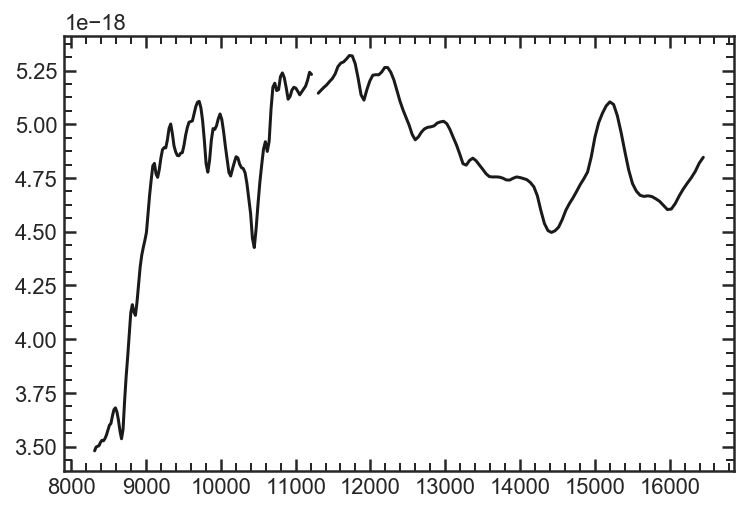

In [206]:

wave, spec = np.load('../data/allsed/phot/{}-{}_mod.npy'.format('GSD', 39170))
Pwv, Pflx, Perr = np.load('../data/allsed/phot/{}-{}.npy'.format('GSD', 39170))

Bwv, Bfl, Ber = np.load('../data/allsed/g102/{}-{}.npy'.format('GSD', 39170))
Bwv, Bmfl = np.load('../data/allsed/g102/{}-{}_mod.npy'.format('GSD', 39170))

Rwv, Rfl, Rer = np.load('../data/allsed/g141/{}-{}.npy'.format('GSD', 39170))
Rwv, Rmfl = np.load('../data/allsed/g141/{}-{}_mod.npy'.format('GSD', 39170))



# # plt.errorbar(Pwv, Pflx, Perr, fmt = 'o')
# plt.errorbar(Bwv, Bfl, Ber, fmt = 'o')
# plt.errorbar(Rwv, Rfl, Rer, fmt = 'o')

# plt.plot(wave*(1+mdb.zgrism[idx]),spec)
plt.plot(Bwv, Bmfl, 'k')
plt.plot(Rwv, Rmfl, 'k')
# plt.xlim(2000,50000)
# plt.xscale('log')

# def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)

def SN(w, f, e, wmin, wmax):
    
    IDx = [U for U in range(len(w)) if wmin < w[U] < wmax and f[U] > 0]
    
    return np.trapz(f[IDx])/ Sig_int(e[IDx])
snr = []
for idx in mdb.index:
    SNB = SNR = 0
    sumB = sumR = 1
    try:
        Bwv, Bfl, Ber = np.load('../data/allsed/g102/{}-{}_O.npy'.format(mdb.field[idx], mdb.id[idx]))
        SNB = SN(Bwv, Bfl, Ber,  Bwv[0], Bwv[-1])
    except:
        sumB = 0
    
    try:
        Rwv, Rfl, Rer = np.load('../data/allsed/g141/{}-{}_O.npy'.format(mdb.field[idx], mdb.id[idx]))
        SNR = SN(Rwv, Rfl, Rer,  Rwv[0], Rwv[-1])
    except:
        sumR = 0
    snr.append((SNB + SNR) / (sumB + sumR))
    
mdb['SNR'] = snr

In [46]:
for idx in mdb.index:
    if mdb.SNR[idx] < 1:
        plt.figure(figsize=[12,6])
        try:
            Bwv, Bfl, Ber = np.load('../data/allsed/g102/{}-{}_O.npy'.format(mdb.field[idx], mdb.id[idx]))
            plt.errorbar(Bwv, Bfl, Ber)
        except:
            pass
        try:
            Rwv, Rfl, Rer = np.load('../data/allsed/g141/{}-{}_O.npy'.format(mdb.field[idx], mdb.id[idx]))
            plt.errorbar(Rwv, Rfl, Rer)
        except:
            pass
        

In [50]:
min(snr)

1.0765687058780784

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


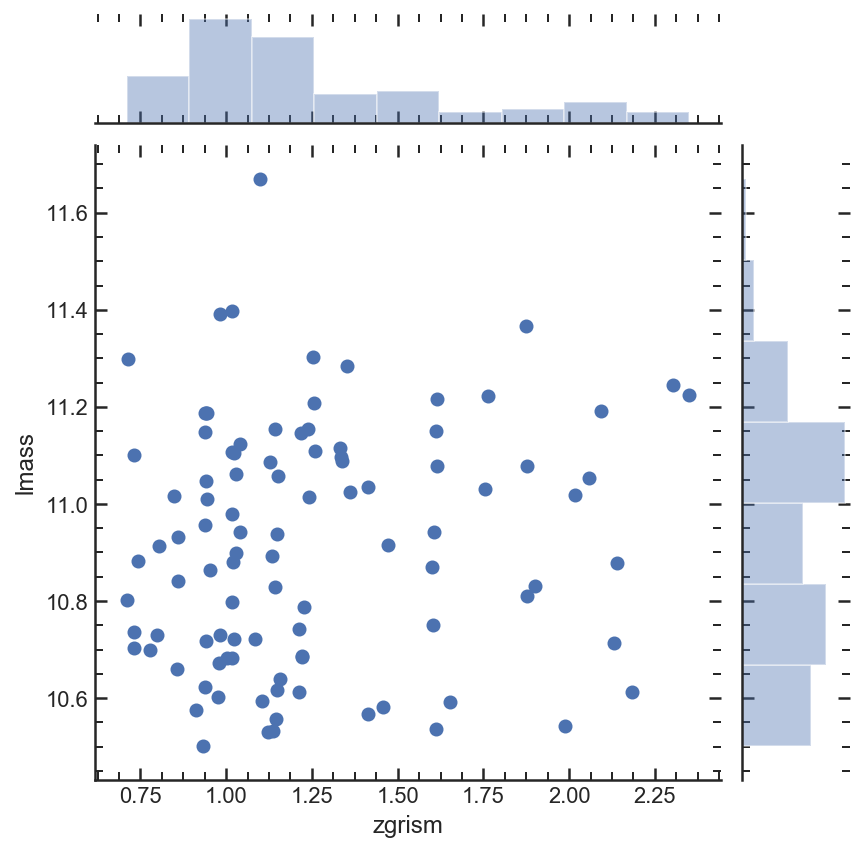

In [51]:
sea.jointplot(mdb.zgrism, mdb.lmass)

In [57]:
def Vol_w_range_z(z1,z2):
    radperarcsec = 1*u.arcsec * ((1*u.arcmin) / (60*u.arcsec)) * ((1*u.degree) / (60*u.arcmin)) * ((np.pi * u.radian) / (180*u.degree))
    allclearsz = ((123 * radperarcsec * 136 * radperarcsec) * 12).value * u.sr
    volume = np.trapz(cosmo.differential_comoving_volume(np.linspace(z1,z2,1000)), np.linspace(z1,z2,1000)) * allclearsz.value
    return volume.value

In [58]:
#  8.5e10 Mpc$^3$ and 6.8e11 Mpc$^3$
print(len(mdb.query('0.7 < zgrism < 1')) / Vol_w_range_z(0.7,1) )
print(len(mdb.query('zgrism > 1')) / Vol_w_range_z(1,2.5) )

0.0008380251293685927
0.0002561444703466918


In [61]:
def Stack(wv, flxgrid , errgrid):
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stack, err

In [83]:
flxgrid = []
errgrid = []
swave = np.arange(3000,8000,10)

for idx in mdb.index:
    wave, flux = np.load('../data/allsed/phot/{}-{}_mod.npy'.format(mdb.field[idx], mdb.id[idx]))

    try:
        Bwv, Bfl, Ber = np.load('../data/allsed/g102/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        Bwv = Bwv[Bfl**2 > 0]
        Ber = Ber[Bfl**2 > 0]
        Bfl = Bfl[Bfl**2 > 0]
    except:
        pass
    try:
        Rwv, Rfl, Rer = np.load('../data/allsed/g141/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        Rwv = Rwv[Rfl**2 > 0]
        Rer = Rer[Rfl**2 > 0]
        Rfl = Rfl[Rfl**2 > 0]
    except:
        pass 

    for i in Bfl:
        if not i**2 >0:
            print(i)
            
    IDX = [U for U in range(len(wave)) if 6000 < wave[U] < 6500]

    Nfact = np.trapz(flux[IDX],wave[IDX])

    sflux = np.zeros(len(swave))
    serror = np.zeros(len(swave))
    try:        
        iBflx =interp1d(Bwv / (1 + mdb.zgrism[idx]),Bfl/ Nfact, fill_value=0, bounds_error=False)(swave)
        iBerr =interp1d(Bwv / (1 + mdb.zgrism[idx]),Ber/ Nfact, fill_value=0, bounds_error=False)(swave)
        sflux += iBflx
        serror += iBerr
    except:
        pass
        
    try:        
        iRflx =interp1d(Rwv / (1 + mdb.zgrism[idx]),Rfl/ Nfact, fill_value=0, bounds_error=False)(swave)
        iRerr =interp1d(Rwv / (1 + mdb.zgrism[idx]),Rer/ Nfact, fill_value=0, bounds_error=False)(swave)
        sflux += iRflx
        serror += iRerr
    except:
        pass
    
    serror[serror == 0] = 1E5

    flxgrid.append(sflux)
    errgrid.append(serror)        

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: i

In [84]:
sflux, serror = Stack(swave, flxgrid, errgrid)

In [96]:
# awave, aflux, aerror = np.load('../data/plot_points/')


FileNotFoundError: [Errno 2] No such file or directory: '../data/plot_points/all_stacked.npy'

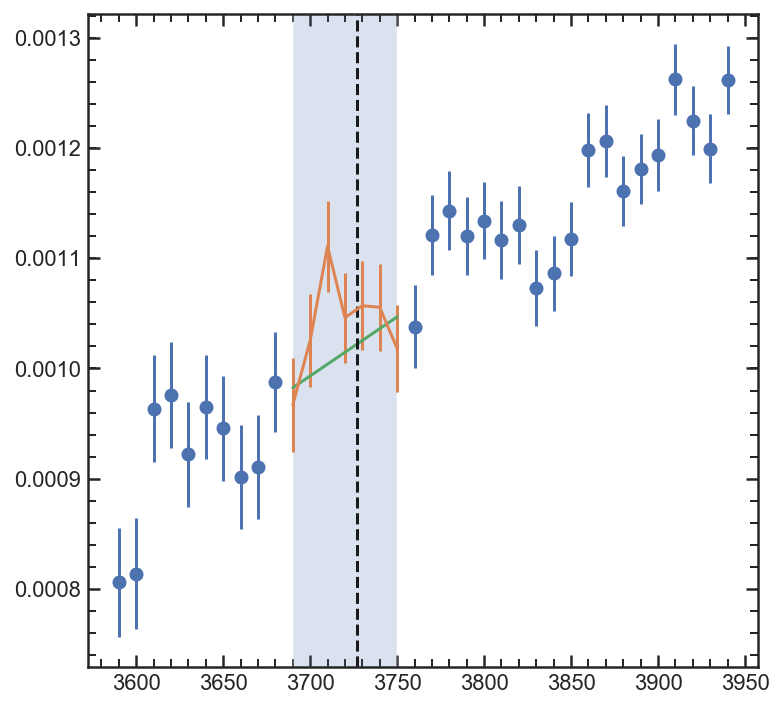

In [127]:
# IDX = [U for U in range(len(swave)) if 3580 < swave[U] < 3950]
plt.figure(figsize=[6,6])
# plt.errorbar(swave[IDX],sflux[IDX], serror[IDX])

IDC = [U for U in range(len(swave)) if 3580 < swave[U] < 3690 or 3750 < swave[U] < 3950]
IDL = [U for U in range(len(swave)) if 3690 <= swave[U] <= 3750]

plt.errorbar(swave[IDC],sflux[IDC], serror[IDC], fmt = 'o')
plt.errorbar(swave[IDL],sflux[IDL], serror[IDL])

pvals = np.polyfit(swave[IDC],sflux[IDC],1)
pline = np.polyval(pvals, swave[IDL])
plt.plot(swave[IDL], pline)

plt.axvline(3727 ,linestyle='--', color = 'k')
#  plt.xlim(3500,4000)
plt.axvspan(3690, 3750, alpha = 0.2)

In [144]:
EW = [] 
for x in range(1000):
    Fgrid = []
    Egrid = []

    IDB = np.random.choice(np.arange(len(flxgrid)), len(flxgrid))

    for i in IDB:
        Fgrid.append(flxgrid[i])
        Egrid.append(errgrid[i])

    sflux, serror = Stack(swave, Fgrid, Egrid)

    IDC = [U for U in range(len(swave)) if 3580 < swave[U] < 3690 or 3750 < swave[U] < 3950]
    IDL = [U for U in range(len(swave)) if 3690 <= swave[U] <= 3750]

    pvals = np.polyfit(swave[IDC],sflux[IDC],1)
    pline = np.polyval(pvals, swave[IDL])

    EW.append(np.trapz(1 - sflux[IDL]/pline, swave[IDL]))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


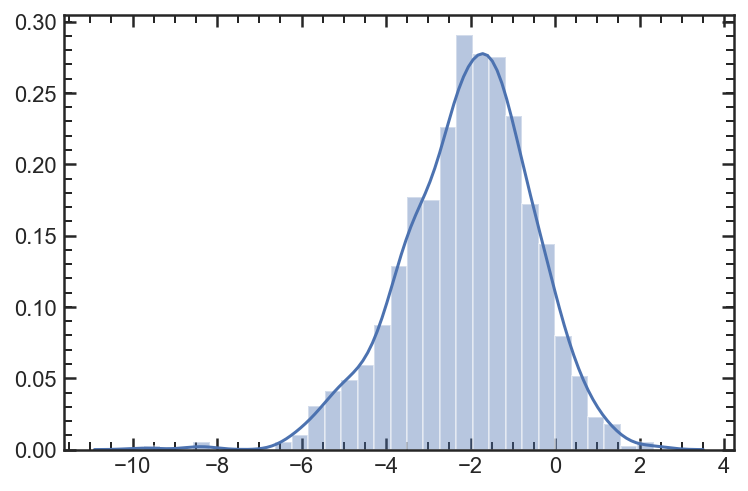

In [145]:
sea.distplot(EW)

In [149]:
np.percentile(EW,50), np.percentile(EW,50) - np.percentile(EW,16) + np.percentile(EW,84) - np.percentile(EW,50)

(-1.9463442498440537, 2.8996763000345815)

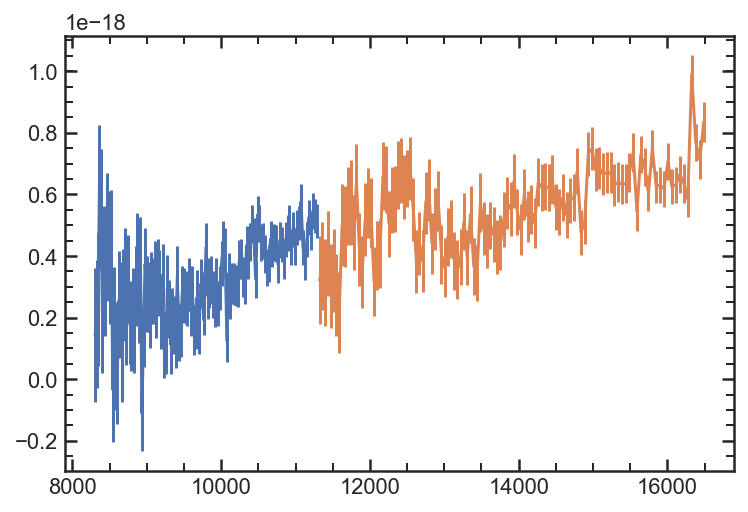

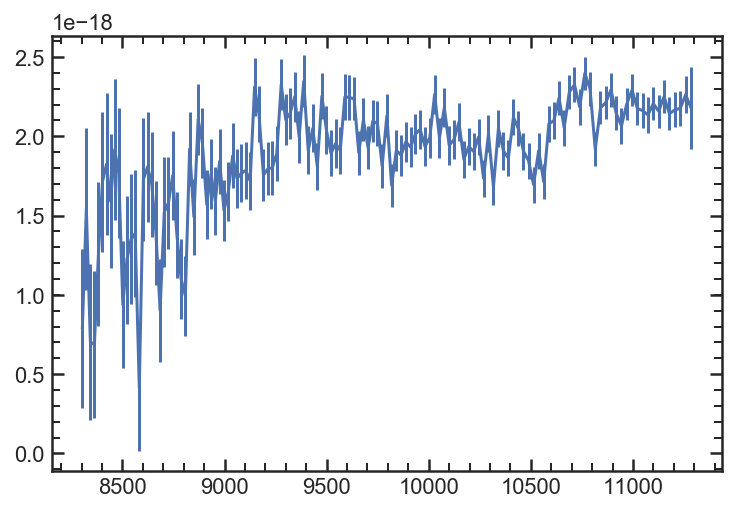

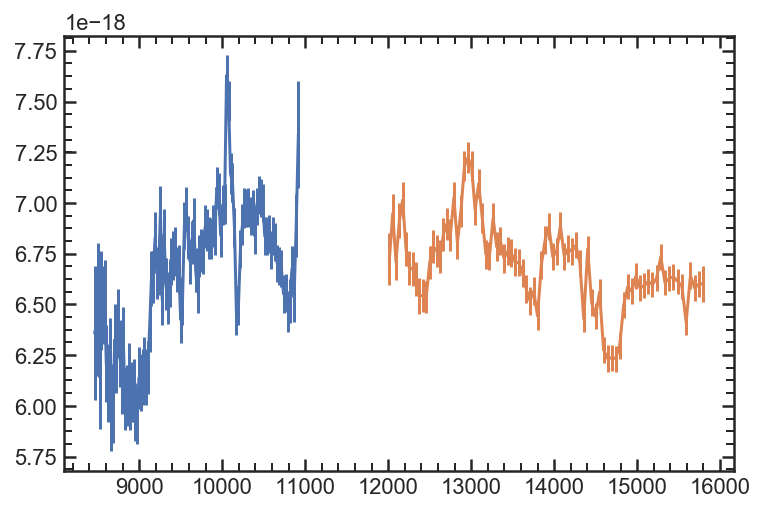

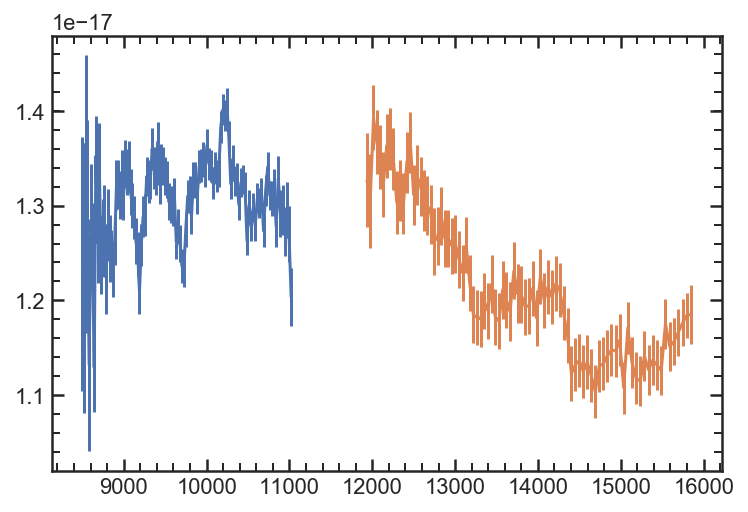

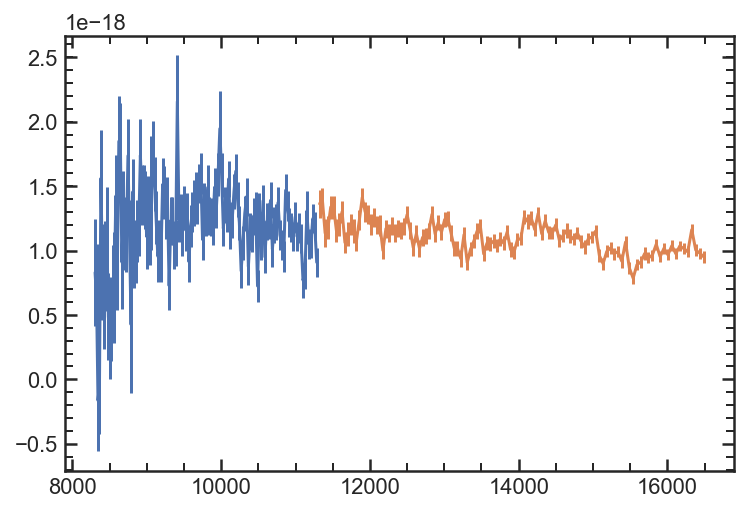

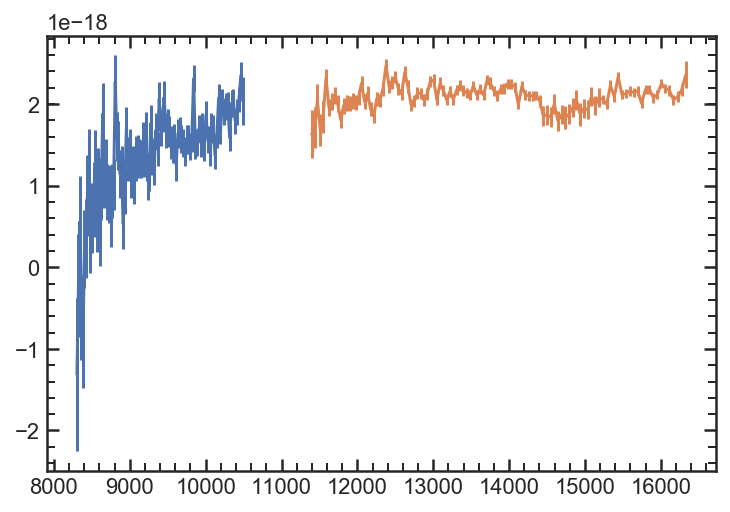

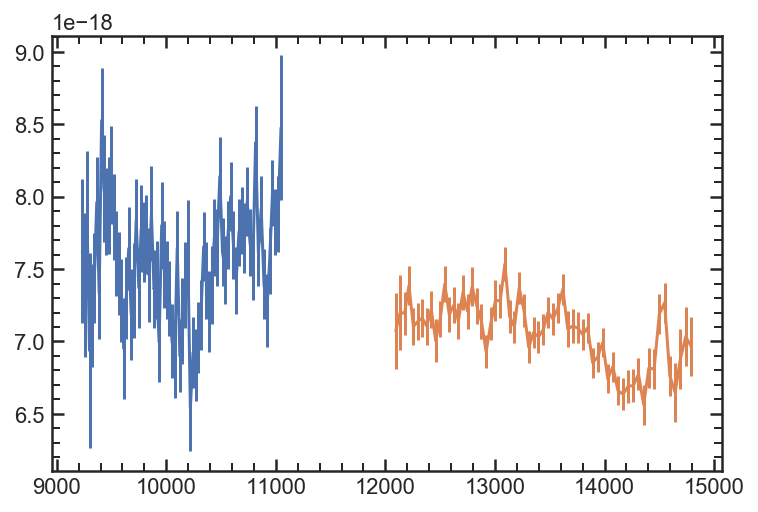

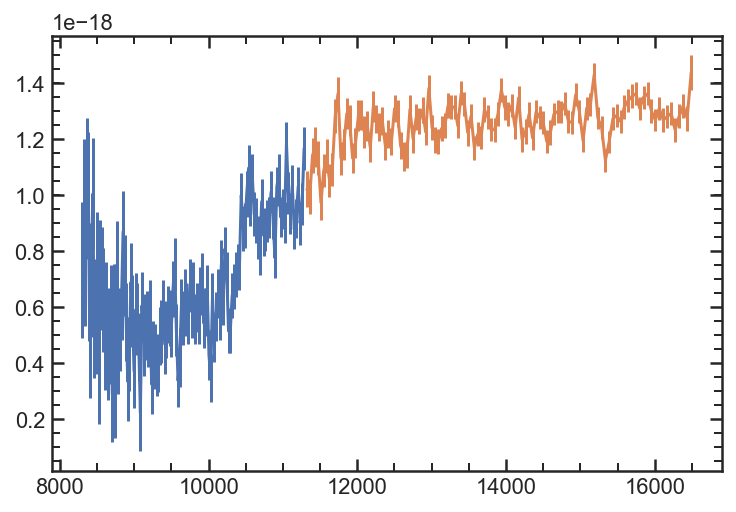

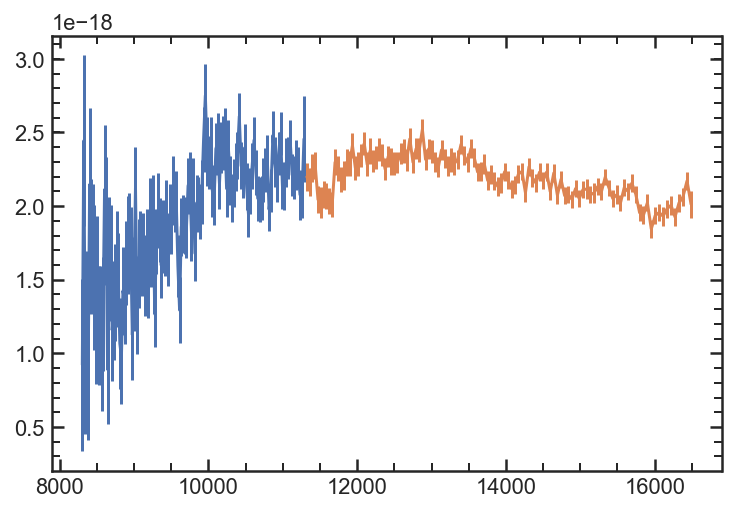

In [136]:
for idx in mdb.index[90:100]:
    plt.figure()
    try:
        Bwv, Bfl, Ber = np.load('../data/allsed/g102/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        plt.errorbar(Bwv, Bfl, Ber)
    except:
        pass
    try:
        Rwv, Rfl, Rer = np.load('../data/allsed/g141/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        plt.errorbar(Rwv, Rfl, Rer)
    except:
        pass 

In [204]:
Blen = []
Rlen = []
for idx in mdb.index:
    try:
        Bwv, Bfl, Ber = np.load('../data/allsed/g102/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        Blen.append(len(Bwv)/131)
    except:
        pass
    try:
        Rwv, Rfl, Rer = np.load('../data/allsed/g141/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        Rlen.append(len(Rwv)/115)
    except:
        pass 

In [205]:
min(Blen), min(Rlen)

(0.5419847328244275, 0.34782608695652173)

In [206]:
Mx_range, Mdm, Mdl, Mdh = np.load('../data/plot_points/mass_lowess.npy')
Sx_range, Sdm, Sdl, Sdh = np.load('../data/plot_points/Sig1_lowess.npy')

In [210]:
Mz = [z_at_value(cosmo.lookback_time, U*u.Gyr) for U in Mdm]
Sz = [z_at_value(cosmo.lookback_time, U*u.Gyr) for U in Sdm]

[ 1.1556191  -9.55685957]


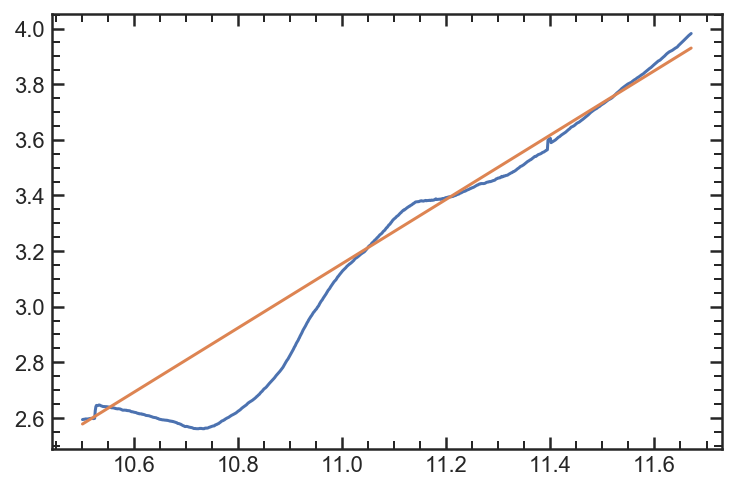

In [215]:
pv = np.polyfit(Mx_range[Mx_range > 11], np.array(Mz)[Mx_range > 11],1)
print(pv)
lfit = np.polyval(pv, Mx_range)
plt.plot(Mx_range, Mz)
plt.plot(Mx_range, lfit)

[  2.65856633 -23.87032223]


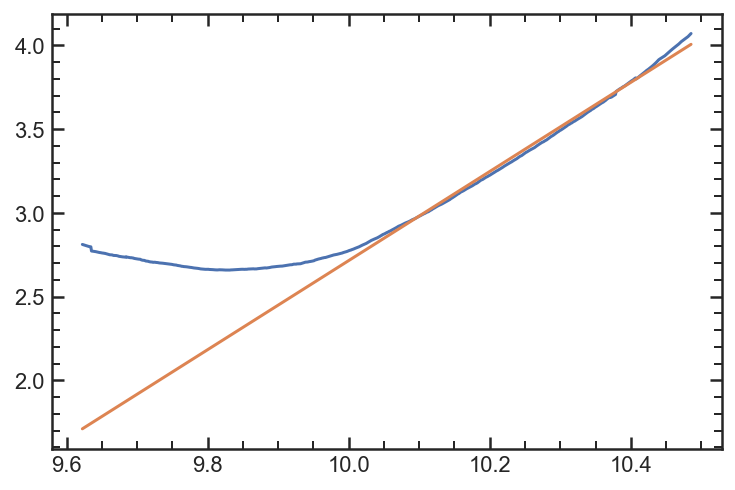

In [217]:
pv = np.polyfit(Sx_range[Sx_range > 10], np.array(Sz)[Sx_range > 10],1)
print(pv)
lfit = np.polyval(pv, Sx_range)
plt.plot(Sx_range, Sz)
plt.plot(Sx_range, lfit)

In [3]:
from bokeh_scripts import RS_img, img_ext

In [4]:
for i in mdb.index:
    IMG = RS_img(img_ext(mdb.field[i], mdb.id[i]))
    np.save('../bokeh_app/data/imgs/{}_img'.format(mdb.id[i]),IMG[::-1]*-1)

In [38]:
import pickle
from spec_tools import Gen_SFH

master_lbt = np.arange(0,6.91, 0.01)
SFH_dict = {'LBT':master_lbt}
for i in mdb.index:
    with open('../data/SFH/{}_{}_1D.pkl'.format( mdb.field[i],  mdb.id[i]), 'rb') as sfh_file:
        SFH = pickle.load(sfh_file)
    
    iSFH = interp1d(SFH.LBT, SFH.SFH, bounds_error=False, fill_value=np.nan)(master_lbt)
    iSFH_16 = interp1d(SFH.LBT, SFH.SFH_16, bounds_error=False, fill_value=np.nan)(master_lbt)
    iSFH_84 = interp1d(SFH.LBT, SFH.SFH_84, bounds_error=False, fill_value=np.nan)(master_lbt)
    
    SFH_dict['{}'.format(mdb.id[i])] = iSFH
    SFH_dict['{}_16'.format(mdb.id[i])] = iSFH_16
    SFH_dict['{}_84'.format(mdb.id[i])] = iSFH_84

    for ii in range(90):
        isfh = interp1d(SFH.fulltimes,SFH.sfr_grid[ii], bounds_error=False, fill_value=np.nan)(master_lbt)
        isfh[isfh == 0] = np.nan        
        SFH_dict['{}_x_{}'.format(mdb.id[i], ii)] = isfh

In [39]:
SFHdf = pd.DataFrame(SFH_dict)
SFHdf.to_pickle('../bokeh_app/data/SFH.pkl')

In [155]:
bwvs = []
rwvs = []
pwvs = []

for idx in mdb.index: 
    wave, spec = np.load('../data/allsed/phot/{}-{}_mod.npy'.format(mdb.field[idx], mdb.id[idx]))

    Pwv, Pflx, Perr = np.load('../data/allsed/phot/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
    pwvs.extend(Pwv)

    try:
        Bwv, Bfl, Ber = np.load('../data/allsed/g102/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        bwvs.extend(Bwv)
    except:
        pass
    try:
        Rwv, Rfl, Rer = np.load('../data/allsed/g141/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        rwvs.extend(Rwv)
    except:
        pass
    
master_Pwvs = np.sort(list(set(pwvs)))
master_Bwvs = np.sort(list(set(bwvs)))
master_Rwvs = np.sort(list(set(rwvs)))

B_dict = {'wave':master_Bwvs}
R_dict = {'wave':master_Rwvs}
P_dict = {'wave':master_Pwvs}
M_dict = {'wave':wave}


for idx in mdb.index:
    rshift = mdb.zgrism[idx]

    wave, spec = np.load('../data/allsed/phot/{}-{}_mod.npy'.format(mdb.field[idx], mdb.id[idx]))
    Pwv, Pflx, Perr = np.load('../data/allsed/phot/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
    
    iPfl = np.repeat(np.nan, len(master_Pwvs))
    iPer = np.repeat(np.nan, len(master_Pwvs))
    for ii in range(len(master_Pwvs)):
        if master_Pwvs[ii] in Pwv:
            iPfl[ii] = Pflx[Pwv == master_Pwvs[ii]]
            iPer[ii] = Perr[Pwv == master_Pwvs[ii]]
    P_dict['{}_F'.format(mdb.id[idx])] = iPfl
    P_dict['{}_E'.format(mdb.id[idx])] = iPer

    
    try:
        Bwv, Bfl, Ber = np.load('../data/allsed/g102/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        Bwv, Bmfl = np.load('../data/allsed/g102/{}-{}_mod.npy'.format(mdb.field[idx], mdb.id[idx]))

        iBfl = np.repeat(np.nan, len(master_Bwvs))
        iBer = np.repeat(np.nan, len(master_Bwvs))
        iBmfl = np.repeat(np.nan, len(master_Bwvs))
        for ii in range(len(master_Bwvs)):
            if master_Bwvs[ii] in Bwv:
                iBfl[ii] = Bfl[Bwv == master_Bwvs[ii]]
                iBer[ii] = Ber[Bwv == master_Bwvs[ii]]
                iBmfl[ii] = Bmfl[Bwv == master_Bwvs[ii]]
                
        B_dict['{}_F'.format(mdb.id[idx])] = iBfl
        B_dict['{}_E'.format(mdb.id[idx])] = iBer
        B_dict['{}_M'.format(mdb.id[idx])] = iBmfl
        
        IDB = Bwv[0]/(1+rshift)
    except:
        IDB = Rwv[0]/(1+rshift)

    try:
        Rwv, Rfl, Rer = np.load('../data/allsed/g141/{}-{}.npy'.format(mdb.field[idx], mdb.id[idx]))
        Rwv, Rmfl = np.load('../data/allsed/g141/{}-{}_mod.npy'.format(mdb.field[idx], mdb.id[idx]))

        iRfl = np.repeat(np.nan, len(master_Rwvs))
        iRer = np.repeat(np.nan, len(master_Rwvs))
        iRmfl = np.repeat(np.nan, len(master_Rwvs))
        for ii in range(len(master_Rwvs)):
            if master_Rwvs[ii] in Rwv:
                iRfl[ii] = Rfl[Rwv == master_Rwvs[ii]]
                iRer[ii] = Rer[Rwv == master_Rwvs[ii]]
                iRmfl[ii] = Rmfl[Rwv == master_Rwvs[ii]]
                
        R_dict['{}_F'.format(mdb.id[idx])] = iRfl
        R_dict['{}_E'.format(mdb.id[idx])] = iRer
        R_dict['{}_M'.format(mdb.id[idx])] = iRmfl
                
        IDR = Rwv[-1]/(1+rshift)
    except:
        IDR = Bwv[-1]/(1+rshift)
        
    ispec = np.repeat(np.nan, len(wave))
    ispec[wave < IDB] = spec[wave<IDB]
    ispec[wave > IDR] = spec[wave>IDR]
    M_dict['{}_F'.format(mdb.id[idx])] = ispec


In [156]:
Bdf = pd.DataFrame(B_dict)
Bdf.to_pickle('../bokeh_app/data/G102.pkl')

Rdf = pd.DataFrame(R_dict)
Rdf.to_pickle('../bokeh_app/data/G141.pkl')

Pdf = pd.DataFrame(P_dict)
Pdf.to_pickle('../bokeh_app/data/PHOT.pkl')

Mdf = pd.DataFrame(M_dict)
Mdf.to_pickle('../bokeh_app/data/MODEL.pkl')

In [ ]:
idx = mdb.query('id == {}'.format(12793)).index:
    
Gs = Gen_spec(mdb.field[idx], mdb.id[idx], mdb.zgrism[idx], phot_errterm = 0.04, irac_err = 0.08,) 
Flam = Posterior_spec(mdb.field[idx], mdb.id[idx])

x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(mdb.field[idx], mdb.id[idx]))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(mdb.field[idx], mdb.id[idx]))
rp1 = x[px == max(px)][0]

np.save('../data/allsed/phot/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[Gs.Pwv, Gs.Pflx, Gs.Perr])

if Gs.g102:
    np.save('../data/allsed/g102/{}-{}_O'.format(mdb.field[idx], mdb.id[idx]),[Gs.Bwv, Gs.Bfl, Gs.Ber])
if Gs.g141:
    np.save('../data/allsed/g141/{}-{}_O'.format(mdb.field[idx], mdb.id[idx]),[Gs.Rwv, Gs.Rfl, Gs.Rer])

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)   

if Gs.g102:
    np.save('../data/allsed/g102/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[Gs.Bwv, Gs.Bfl, Gs.Ber])
    np.save('../data/allsed/g102/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[Gs.Bwv,Gs.Bmfl])

if Gs.g141:
    np.save('../data/allsed/g141/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[Gs.Rwv, Gs.Rfl, Gs.Rer])
    np.save('../data/allsed/g141/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[Gs.Rwv,Gs.Rmfl])

np.save('../data/allsed/phot/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[Flam.wave,Flam.SPEC])

In [14]:
mdb.query('id == {}'.format(35774)).zgrism

141    1.25677
Name: zgrism, dtype: float64

In [151]:
from grizli.utils import SpectrumTemplate
temps = {}
idx = mdb.query('id ==27006').index.values[0]

# Gs2 = Gen_spec_2D(mdb.field[idx], mdb.id[idx], mdb.zgrism[idx], g102_lims=[8300, 11288], 
#                      g141_lims=[11288, 16500],phot_errterm = 0.04, irac_err = 0.08,) 
Gs = Gen_spec(mdb.field[idx], mdb.id[idx], mdb.zgrism[idx], g102_lims=[8300, 11288], 
                     g141_lims=[13000, 16500],phot_errterm = 0.04, irac_err = 0.08,decontam = False) 
wave, spec = np.load('../data/allsed/phot/{}-{}_mod.npy'.format(mdb.field[idx], mdb.id[idx]))
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(mdb.field[idx], mdb.id[idx]))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(mdb.field[idx], mdb.id[idx]))
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(wave, spec, mdb.zgrism[idx], bp1, rp1)   

# if Gs.g102:
#     temps['fsps_model'] = SpectrumTemplate(wave=wave, flux=spec*1E18)
#     fit = Gs2.mb_g102.template_at_z(mdb.zgrism[idx], templates = temps, fitter='lstsq')
#     Bw,Bf,Be,Bm = Extract_grism_fit(Gs2.mb_g102, fit, 'G102', [8300,11300])
#     BS1 = Scale_model(interp1d(wave*(1+mdb.zgrism[idx]),spec)(Bw), np.ones_like(Bw), Bm)
#     BS2 = Scale_model(Bf,Be, Bm*BS1)
# #         np.save('../data/allsed/g102/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[w,f/S2,e/S2])
# #         np.save('../data/allsed/g102/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[w,m*S1])

# if Gs.g141:
#     temps['fsps_model'] = SpectrumTemplate(wave=wave, flux=spec*1E18)
#     fit = Gs2.mb_g141.template_at_z(mdb.zgrism[idx], templates = temps, fitter='lstsq')
#     Rw,Rf,Re,Rm = Extract_grism_fit(Gs2.mb_g141, fit, 'G141', [11300, 16500])
#     RS1 = Scale_model(interp1d(wave*(1+mdb.zgrism[idx]),spec)(Rw), np.ones_like(Rw), Rm)
#     RS2 = Scale_model(Rf,Re, Rm*RS1)
#         np.save('../data/allsed/g141/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[w,f/S2,e/S2])
#         np.save('../data/allsed/g141/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[w,m*S1])


1 icat22c9q_flt.fits G102
2 icat22ceq_flt.fits G102
3 icat22clq_flt.fits G102
4 icat22cqq_flt.fits G102
5 icxt62lkq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102
13 icxt64qrq_flt.fits G102
14 icxt64qsq_flt.fits G102
15 icxt64qvq_flt.fits G102
16 icxt64qxq_flt.fits G102
17 icxt65evq_flt.fits G102
18 icxt65ewq_flt.fits G102
19 icxt65ezq_flt.fits G102
20 icxt65f1q_flt.fits G102
21 ib3722j5q_flt.fits G141
22 ib3722j9q_flt.fits G141
23 ib3722jlq_flt.fits G141
24 ib3722jpq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)


1 icat22c9q_flt.fits G102
2 icat22ceq_flt.fits G102
3 icat22clq_flt.fits G102
4 icat22cqq_flt.fits G102
5 ib3722j5q_flt.fits G141
6 ib3722j9q_flt.fits G141
7 ib3722jlq_flt.fits G141
8 ib3722jpq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


1 icat22c9q_flt.fits G102
2 icat22ceq_flt.fits G102
3 icat22clq_flt.fits G102
4 icat22cqq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 icxt62lkq_flt.fits G102
6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102
13 icxt64qrq_flt.fits G102
14 icxt64qsq_flt.fits G102
15 icxt64qvq_flt.fits G102
16 icxt64qxq_flt.fits G102
17 icxt65evq_flt.fits G102
18 icxt65ewq_flt.fits G102
19 icxt65ezq_flt.fits G102
20 icxt65f1q_flt.fits G102
21 ib3722j5q_flt.fits G141
22 ib3722j9q_flt.fits G141
23 ib3722jlq_flt.fits G141
24 ib3722jpq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)


1 icat22c9q_flt.fits G102
2 icat22ceq_flt.fits G102
3 icat22clq_flt.fits G102
4 icat22cqq_flt.fits G102
5 ib3722j5q_flt.fits G141
6 ib3722j9q_flt.fits G141
7 ib3722jlq_flt.fits G141
8 ib3722jpq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


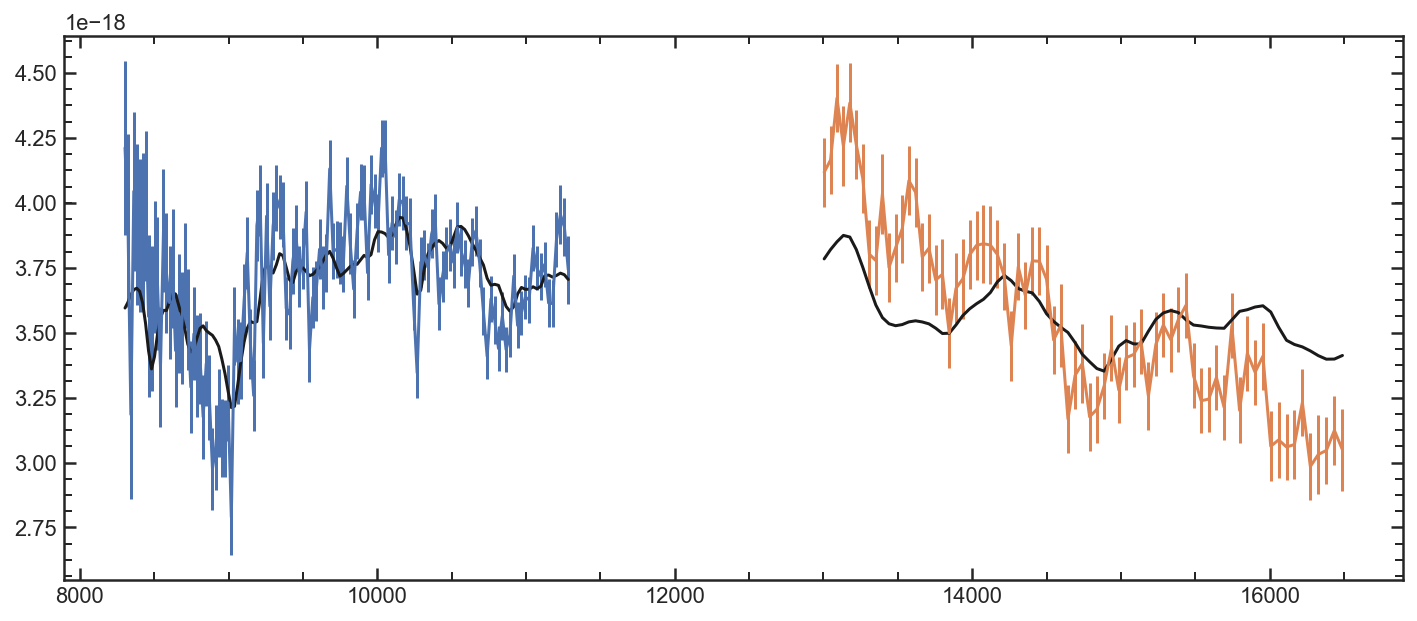

In [152]:
# plt.figure(figsize=[12,5])
# plt.errorbar(Bw,Bf/BS2,Be/BS2)
# plt.errorbar(Rw,Rf/RS2,Re/RS2)
# plt.plot(Bw, Bm, 'k')
# plt.plot(Rw, Rm, 'k')
# IDX = [U for U in range(len(Gs.Bwv)) if Gs.Bwv[U] < 9000 or Gs.Bwv[U] > 9400]
plt.figure(figsize=[12,5])
plt.errorbar(Gs.Bwv ,Gs.Bfl, Gs.Ber)
plt.errorbar(Gs.Rwv ,Gs.Rfl, Gs.Rer)
plt.plot(Gs.Bwv ,Gs.Bmfl, 'k')
plt.plot(Gs.Rwv ,Gs.Rmfl, 'k')

In [153]:
# np.save('../data/allsed/g102/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[Bw,Bf/BS2,Be/BS2])
# np.save('../data/allsed/g102/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[Bw,Bm*BS1])
# np.save('../data/allsed/g141/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[Rw,Rf/RS2,Re/RS2])
# np.save('../data/allsed/g141/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[Rw,Rm*RS1])

np.save('../data/allsed/g102/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[Gs.Bwv ,Gs.Bfl, Gs.Ber])
np.save('../data/allsed/g102/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[Gs.Bwv ,Gs.Bmfl])
np.save('../data/allsed/g141/{}-{}'.format(mdb.field[idx], mdb.id[idx]),[Gs.Rwv ,Gs.Rfl, Gs.Rer])
np.save('../data/allsed/g141/{}-{}_mod'.format(mdb.field[idx], mdb.id[idx]),[Gs.Rwv ,Gs.Rmfl])


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)


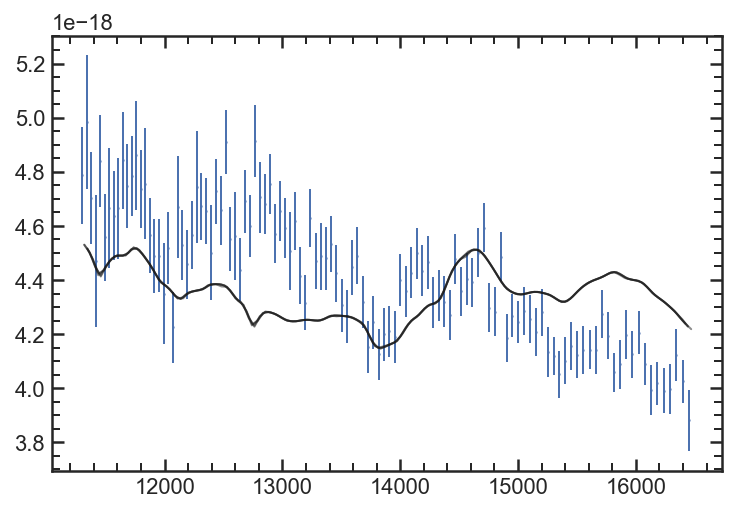

In [27]:

ax = plt.subplot()
Plot_grism_fit(Gs2.mb_g141, fit, 'G141',ax, 'b', [11300, 16500])

In [30]:
Gs.Rfl

array([3.88112556e-18, 3.81977732e-18, 3.85941194e-18, 3.74401191e-18,
       3.85827126e-18, 3.68442704e-18, 3.83605609e-18, 3.87830327e-18,
       3.82288924e-18, 3.87580699e-18, 3.99771698e-18, 4.01953160e-18,
       4.05079815e-18, 4.04254104e-18, 4.08064091e-18, 4.02694267e-18,
       4.29726359e-18, 4.08267226e-18, 3.87805987e-18, 3.85578020e-18,
       4.14524481e-18, 4.06974467e-18, 4.04457132e-18, 4.15566425e-18,
       4.08777507e-18, 4.15813426e-18, 3.96457834e-18, 4.09944247e-18,
       4.14024161e-18, 3.93983345e-18, 4.06408491e-18, 3.94672325e-18,
       3.82038022e-18, 3.90549776e-18, 4.06469526e-18, 3.97324520e-18,
       3.96556416e-18, 4.02778879e-18, 3.93810123e-18, 3.83552038e-18,
       3.80574235e-18, 3.95580501e-18, 3.94051854e-18, 3.93616400e-18,
       3.80943890e-18, 3.73769295e-18, 3.83223043e-18, 3.72363306e-18,
       3.83469333e-18, 3.69000668e-18, 3.92590317e-18, 3.97364700e-18,
       4.03887395e-18, 3.98803646e-18, 4.05381940e-18, 4.11168290e-18,
      

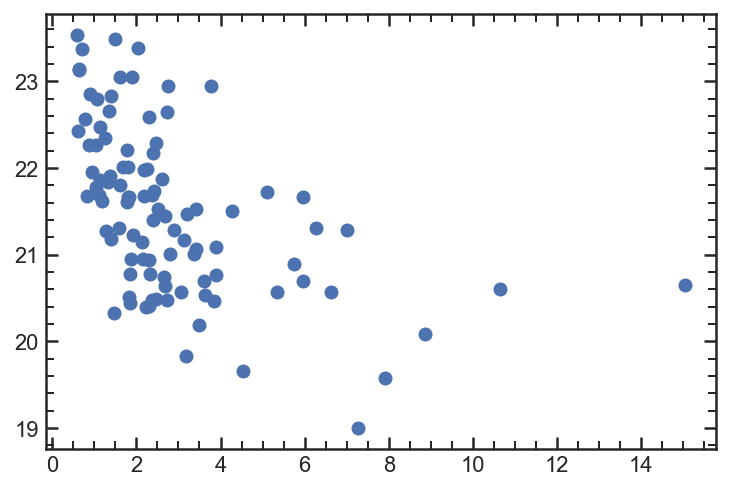

In [86]:
plt.scatter(mdb.Rm, mdb.mag_f125)

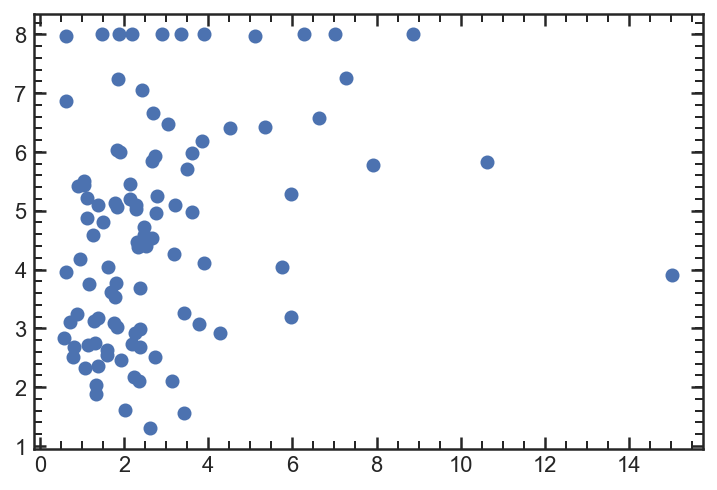

In [87]:
plt.scatter(mdb.Rm, mdb.n)

In [97]:
mlims = [0, 20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25]
rlims = [0,0.75,1.25,1.75,2.25]
nlims = [0,1,2.5]

errs = {}
errs['0'] = [0.002,0.003,0.010,0.002,0.006,0.018,0.004,0.009,0.024,0.005,0.012,0.031]
errs['1'] = [0.003,0.005,0.017,0.004,0.009,0.031,0.005,0.015,0.044,0.008,0.019,0.065]
errs['2'] = [0.005,0.009,0.025,0.006,0.017,0.046,0.010,0.025,0.067,0.013,0.031,0.101]
errs['3'] = [0.006,0.015,0.048,0.011,0.025,0.059,0.015,0.036,0.086,0.017,0.053,0.256]
errs['4'] = [0.014,0.024,0.068,0.018,0.042,0.113,0.023,0.056,0.410,0.031,0.087,1.033]
errs['5'] = [0.018,0.038,0.095,0.027,0.063,0.152,0.036,0.089,0.222,0.053,0.129,3.571]
errs['6'] = [0.033,0.056,0.153,0.044,0.089,0.213,0.063,0.116,0.275,0.093,0.200,3.360]
errs['7'] = [0.060,0.108,0.186,0.071,0.138,0.332,0.086,0.194,0.384,0.132,0.273,3.243]

In [83]:
Rm_nsig = []
Ra_nsig = []
Re_nsig = []

for i in alldb.index:
    Rm_nsig.append(np.sqrt(alldb.Rm_sig[i]**2 + (0.06*alldb.Rm[i])**2))
    Ra_nsig.append(np.sqrt(alldb.Ra_sig[i]**2 + (0.06*alldb.Ra[i])**2))
    Re_nsig.append(np.sqrt(alldb.Re_sig[i]**2 + (0.06*alldb.Rm[i])**2))
    
alldb['Rm_nsig'] = Rm_nsig
alldb['Ra_nsig'] = Ra_nsig
alldb['Re_nsig'] = Re_nsig

In [84]:
alldb.to_pickle('../dataframes/fitdb/allfits_1D.pkl')


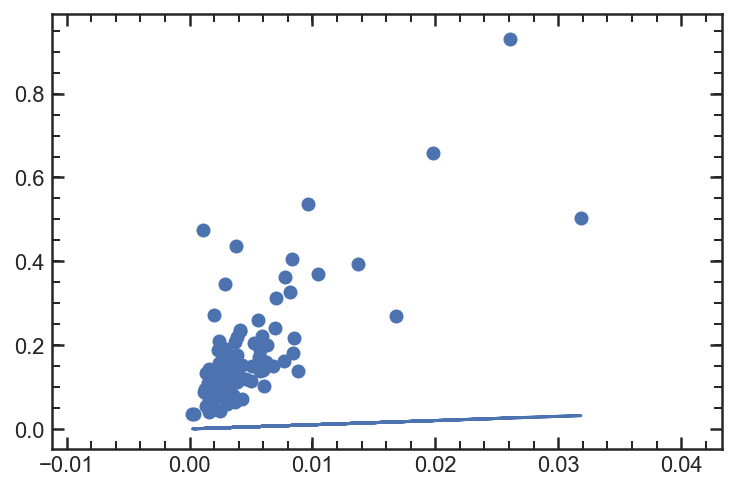

In [82]:
plt.scatter(mdb.Ra_sig, nerr)
plt.plot(mdb.Ra_sig, mdb.Ra_sig)


<ErrorbarContainer object of 3 artists>

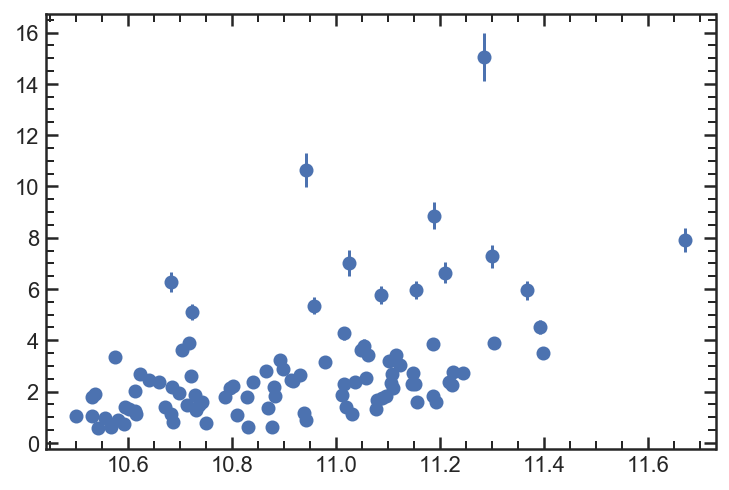

In [81]:
plt.errorbar(mdb.lmass, mdb.Rm, nerr, fmt='o')

In [120]:
BDB = pd.read_pickle('../bokeh_app/data/G102.pkl')


In [137]:
mb = multifit.MultiBeam('../beams/GN4_21683.beams.fits')

1 icat26dtq_flt.fits G102
2 icat26dyq_flt.fits G102
3 icat26e5q_flt.fits G102
4 icat26eaq_flt.fits G102
5 icxt62lkq_flt.fits G102
6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


13 icxt61gvq_flt.fits G102
14 icxt61gwq_flt.fits G102
15 icxt61gzq_flt.fits G102
16 icxt61h1q_flt.fits G102
17 icxt64qrq_flt.fits G102
18 icxt64qsq_flt.fits G102
19 icxt64qvq_flt.fits G102
20 icxt64qxq_flt.fits G102
21 icxt65evq_flt.fits G102
22 icxt65ewq_flt.fits G102
23 icxt65ezq_flt.fits G102
24 icxt65f1q_flt.fits G102
25 ib3726bpq_flt.fits G141
26 ib3726btq_flt.fits G141
27 ib3726c5q_flt.fits G141
28 ib3726c9q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)


In [143]:
# mb.fit_redshift(zr = [0.6,2])

In [124]:
mwv = BDB.wave
bfl = BDB['21683_F']
ber = BDB['21683_E']
bmfl = BDB['21683_M']

In [129]:
mdb.query('id == 21683').zgrism

269    0.714636
Name: zgrism, dtype: float64

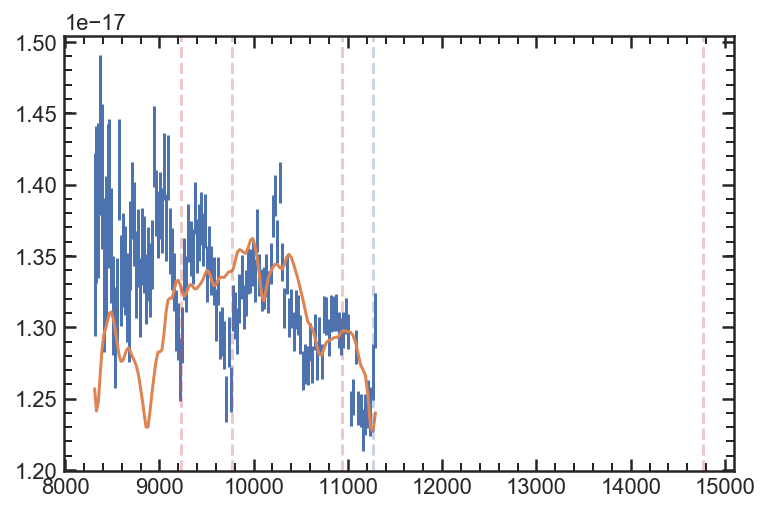

In [134]:
rshift = 1.25
plt.errorbar(mwv,bfl,ber)
plt.plot(mwv[bmfl**2>0],bmfl[bmfl**2>0])
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')

In [140]:
idx = mdb.query('id == 27006').index.values[0]

In [148]:
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(mdb.field[idx], mdb.id[idx]))
rshift = x[px == max(px)][0]
print(rshift)
Gs = Gen_spec(mdb.field[idx], mdb.id[idx], rshift, g102_lims=[8300, 11288], 
                     g141_lims=[13000, 16500],phot_errterm = 0.04, irac_err = 0.08,decontam = True) 
Flam = Posterior_spec(mdb.field[idx], mdb.id[idx])

wave, spec = np.load('../data/allsed/phot/{}-{}_mod.npy'.format(mdb.field[idx], mdb.id[idx]))
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(mdb.field[idx], mdb.id[idx]))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(mdb.field[idx], mdb.id[idx]))
rp1 = x[px == max(px)][0]

# rshift = 0.87
Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC,rshift, bp1, rp1)   


0.7434810041628173
1 icat22c9q_flt.fits G102
2 icat22ceq_flt.fits G102
3 icat22clq_flt.fits G102
4 icat22cqq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 icxt62lkq_flt.fits G102
6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102
13 icxt64qrq_flt.fits G102
14 icxt64qsq_flt.fits G102
15 icxt64qvq_flt.fits G102
16 icxt64qxq_flt.fits G102
17 icxt65evq_flt.fits G102
18 icxt65ewq_flt.fits G102
19 icxt65ezq_flt.fits G102
20 icxt65f1q_flt.fits G102
21 ib3722j5q_flt.fits G141
22 ib3722j9q_flt.fits G141
23 ib3722jlq_flt.fits G141
24 ib3722jpq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)


1 icat22c9q_flt.fits G102
2 icat22ceq_flt.fits G102
3 icat22clq_flt.fits G102
4 icat22cqq_flt.fits G102
5 ib3722j5q_flt.fits G141
6 ib3722j9q_flt.fits G141
7 ib3722jlq_flt.fits G141
8 ib3722jpq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


1 icat22c9q_flt.fits G102
2 icat22ceq_flt.fits G102
3 icat22clq_flt.fits G102
4 icat22cqq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 icxt62lkq_flt.fits G102
6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102
13 icxt64qrq_flt.fits G102
14 icxt64qsq_flt.fits G102
15 icxt64qvq_flt.fits G102
16 icxt64qxq_flt.fits G102
17 icxt65evq_flt.fits G102
18 icxt65ewq_flt.fits G102
19 icxt65ezq_flt.fits G102
20 icxt65f1q_flt.fits G102
21 ib3722j5q_flt.fits G141
22 ib3722j9q_flt.fits G141
23 ib3722jlq_flt.fits G141
24 ib3722jpq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)


1 icat22c9q_flt.fits G102
2 icat22ceq_flt.fits G102
3 icat22clq_flt.fits G102
4 icat22cqq_flt.fits G102
5 ib3722j5q_flt.fits G141
6 ib3722j9q_flt.fits G141
7 ib3722jlq_flt.fits G141
8 ib3722jpq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


(8000, 17000)

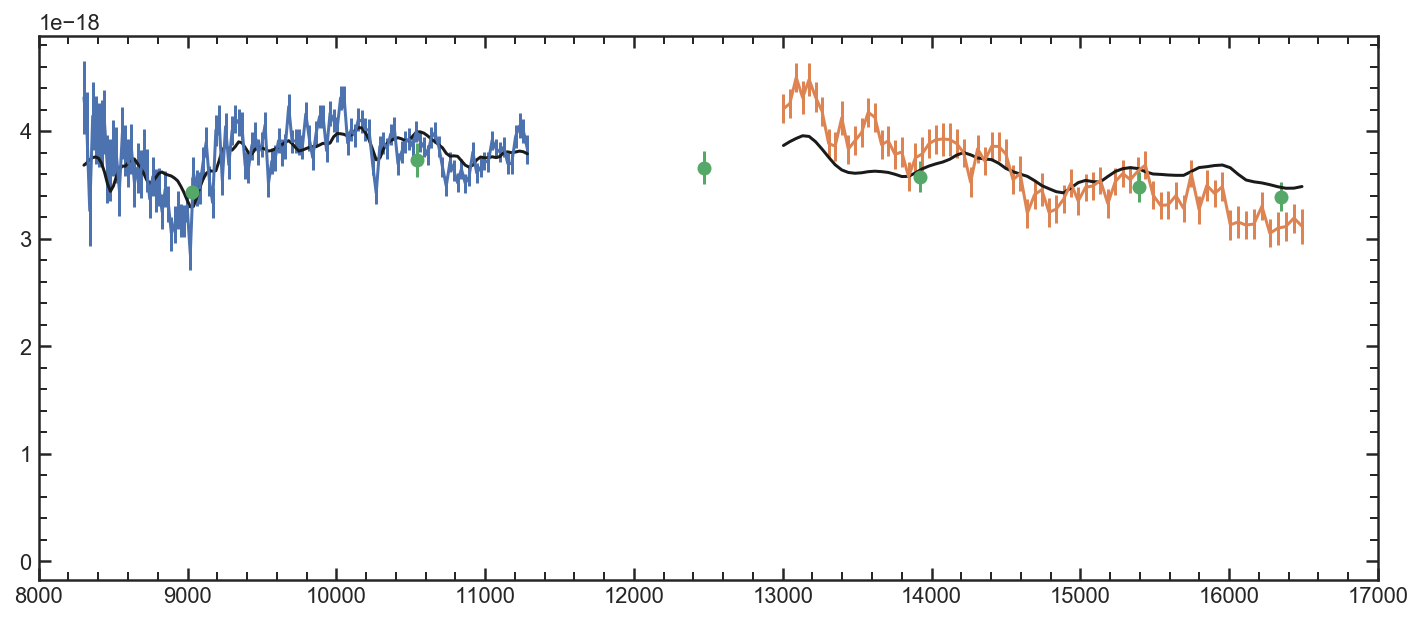

In [150]:
plt.figure(figsize=[12,5])
plt.errorbar(Gs.Bwv ,Gs.Bfl, Gs.Ber)
plt.errorbar(Gs.Rwv ,Gs.Rfl, Gs.Rer)
plt.errorbar(Gs.Pwv ,Gs.Pflx, Gs.Perr, fmt = 'o')
plt.plot(Gs.Bwv ,Gs.Bmfl, 'k')
plt.plot(Gs.Rwv ,Gs.Rmfl, 'k')
# plt.plot(Flam.wave*(1+rshift), Flam.SPEC)
# plt.xscale('log')
plt.xlim(8000,17000)

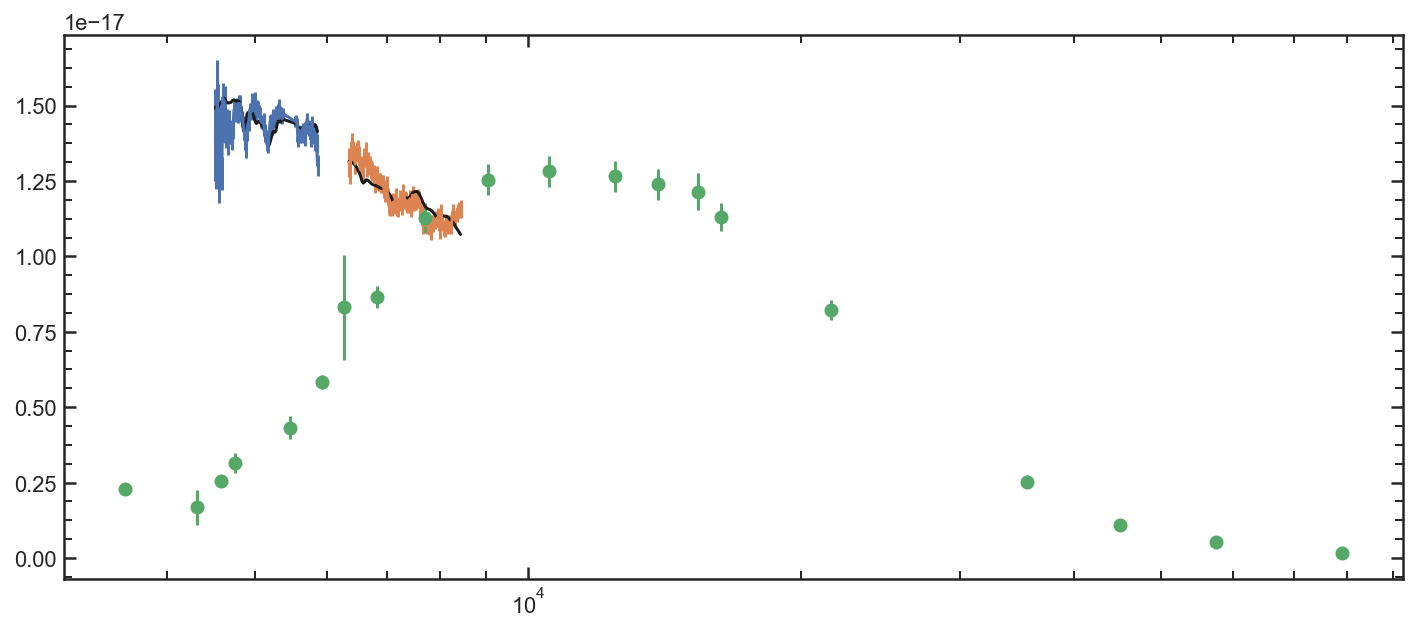

In [124]:
plt.figure(figsize=[12,5])
plt.errorbar(Gs.Bwv/(1+rshift) ,Gs.Bfl, Gs.Ber)
plt.errorbar(Gs.Rwv/(1+rshift) ,Gs.Rfl, Gs.Rer)
plt.errorbar(Gs.Pwv ,Gs.Pflx, Gs.Perr, fmt = 'o')
plt.plot(Gs.Bwv/(1+rshift) ,Gs.Bmfl, 'k')
plt.plot(Gs.Rwv/(1+rshift) ,Gs.Rmfl, 'k')
plt.xscale('log')

In [112]:
np.log10(mdb.query('id == 21683').Sigma1)

269    10.207751
Name: Sigma1, dtype: float64

In [120]:
sfh = Gen_SFH('GND', 21683, 0.88)

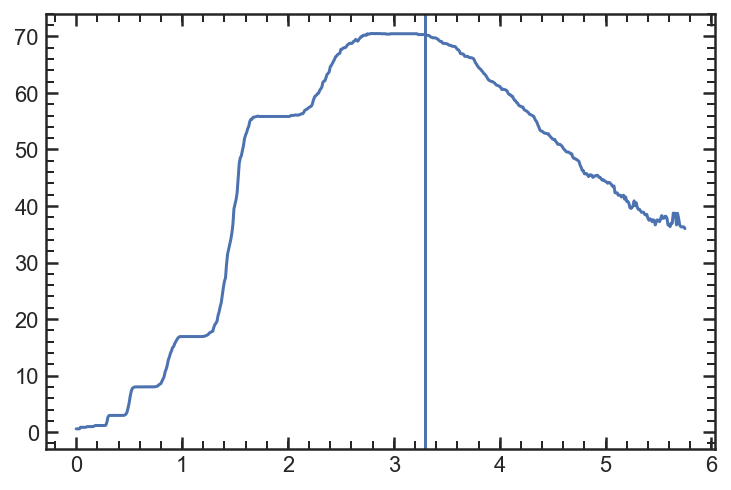

In [121]:
plt.plot(sfh.LBT,sfh.SFH)
plt.axvline(sfh.t_50)

In [122]:
cosmo.lookback_time(sfh.z_50) - cosmo.lookback_time(0.89)

<Quantity 3.25304141 Gyr>

In [123]:
sfh.z_50

2.1314329877900744